# Práctica: Redes Bayesianas Multinomiales - Aprendizaje

## Master in Data Science - Machine Learning II
## Santander Meteorology Group

## 1 Introducción a la práctica

La presente práctica esta concebida como una primera aproximación a los fundamentos de la Redes Bayesianas. Utilizaremos los datos de una encuesta sobre utilización de medios de transporte. La práctica se centra en la modelización de variables discretas mediante una *Red Bayesiana Multinomial*.

Este tipo de red se construye con variables aleatorias discretas, es decir, que cada variable tiene un número finito de posibles estados. Asimismo, se considera que la probabilidad condicional de cada variable dados sus padres es multinomial, y por lo tanto, ésta viene dada por la tabla de probabilidades correspondientes a las diferentes combinaciones de estados entre las variables implicadas.

La práctica ilustra los pasos a seguir en entorno R para:

1. Construir un grafo acíclico dirigido (DAG, de las siglas en inglés de *directed acyclic graph*)
2. Definición de la función de probabilidad conjunta (FPC)
3. Definición de los parámetros del modelo (*aprendizaje paramétrico*)
4. Obtener nueva información a partir de una evidencia dada (*inferencia*)
5. Aprendizaje automático del grafo de una red bayesiana a partir de los datos (*aprendizaje estructural*)
6. Representación gráfica del modelo

### 1.1 Dataset de ejemplo: 'survey'

A partir de los datos de campo recogidos por la encuesta, se investigará la selección de medios de transporte por distintos perfiles de usuarios, y particularmente a la preferencia de tren o coche. Este tipo de análisis se utilizan con frecuencia en la planificación de infraestructuras. Para cada individuo encuestado, se han recopilado datos referenctes a 6 variables discretas. Las abreviaturas de dichas variables se muestran entre paréntesis, y se utilizarán a lo largo de la práctica para referirse a los nodos de la red creada. Tanto las abreviaturas como los nombres de las variables preservan la nomenclatura original del dataset en inglés.

* Edad (`A`): Edad del encuestado, agrupado en los siguientes estados: joven (`young`, < 30 años), adulto (`adult`, 30 < edad <= 60) y anciano (`old`, edad > 60).
* Sexo (`S`): Sexo del encuestado, con sus dos posibles estado: masculino (`M`) y femenino (`F`).
* Educación (`E`): Nivel más alto de educación alcanzado. Hasta educación secundaria (`high`) o título universitario (`uni`).
* Ocupación (`O`): Considera dos estados: trabajador por cuenta ajena (`emp`) o autónomo (`self`).
* Residencia (`R`): El tamaño de la población de residencia del individuo. Estados posibles: `big` y `small`.
* Transporte (`T`): El medio de transporte más utilizado por el encuestado para acudir al trabajo, diferenciando 3 posibles estados: `car`, `train` y `other`.

### 1.2 Paquetes de R necesarios

Se utilizará el paquete de R `bnlearn` (**b**ayesian **n**etwork **lear**ning), disponible a través del CRAN. Por tanto, su instalación es directa si no lo tenemos previamente instalado:

```r
if (!require(bnlearn)) install.packages("bnlearn")
```

Además, se necesitan dependencias adicionales para la parte relacionada con la inferencia:

```r
# Paquete RBGL (disponible en bioconductor)
if (!require(RBGL)) {
      source("http://bioconductor.org/biocLite.R")
      biocLite("RBGL")
}
# Paquete gRain
if (!require(gRain)) install.packages("gRain")
```

, y para la parte de visualización de grafos:

```r
if (!require(Rgraphviz)) {
    source("http://bioconductor.org/biocLite.R")
    biocLite("Rgraphviz")
}
```

In [1]:
library(bnlearn)
library(RBGL)
library(gRain)
library(Rgraphviz)


Attaching package: ‘bnlearn’

The following object is masked from ‘package:stats’:

    sigma

Loading required package: graph
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:bnlearn’:

    score

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rowna

## 2 Construcción de la red Bayesiana

### 2.1 Dibujar la estructura de la red

Para crear un grafo que contenga un nodo por cada variable considerada en la encuesta utilizamos la función `empty.graph`:

In [2]:
dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

Nombramos a nuestro grafo vacío `dag`, que es un acrónimo de *directed acyclic graph*, o gráfico acíclico dirigido, en referencia a las principales propiedades de este tipo de grafos, y que ya sen visto durante las sesiones teórico-prácticas.

Esta es la información contenida en el grafo, que es un objeto de la clase `bn`:

In [3]:
class(dag)

[1] "bn"

In [4]:
print(dag)


  Random/Generated Bayesian network

  model:
   [A][S][E][O][R][T] 
  nodes:                                 6 
  arcs:                                  0 
    undirected arcs:                     0 
    directed arcs:                       0 
  average markov blanket size:           0.00 
  average neighbourhood size:            0.00 
  average branching factor:              0.00 

  generation algorithm:                  Empty 



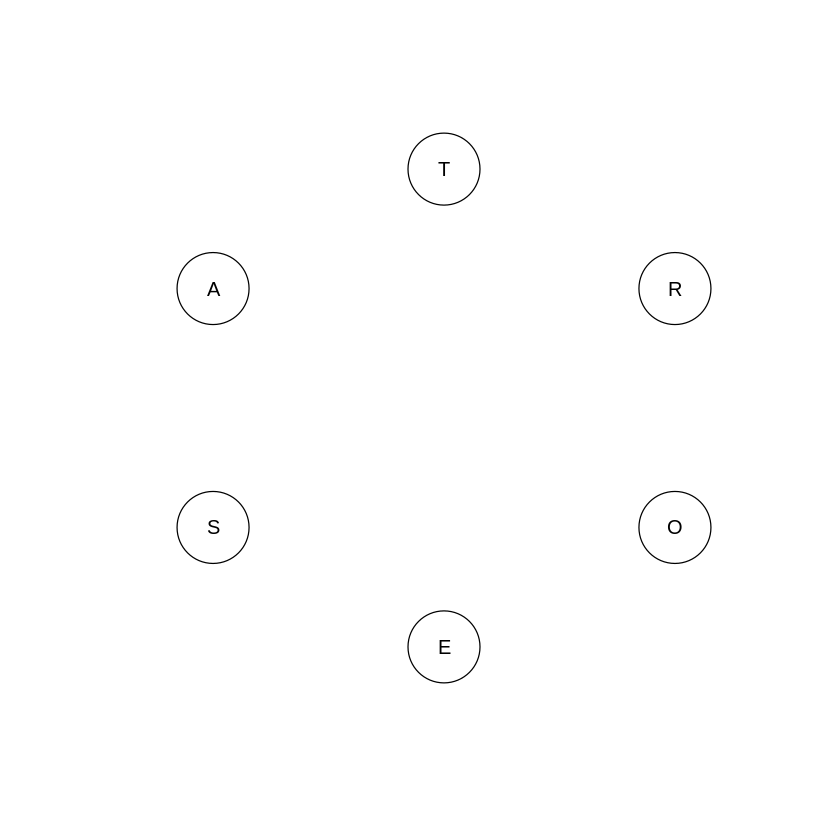

In [5]:
plot(dag)

En [secciones posteriores](#draw.dag) veremos como hacer representaciones gráficas más detalladas, pero de momento basta con aplicar el método `plot` para ir viendo la estructura básica de la red. Una vez creados los nodos, comenzamos a añadir los arcos que definen las dependencias directas entre las diferentes variables. 

La edad y el sexo son indicadores demográficos y no reciben influencia de ninguna otra variable, ya que son características intrínsecas del individuo. Por lo tanto, ninguno de los arcos del grafo apuntan hacia ellas. Por otra parte, ambas variables (sexo y edad) si tienen una influencia directa sobre el nivel de educación, ya que el número de estudiantes universitarios ha aumentado en las últimas décadas, y por lo tanto personas más jóvenes tienen más probabilidad de tener un título universitario que otras más mayores.

In [6]:
dag <- set.arc(dag, from = "A", to = "E")

Del mismo modo, el sexo tiene influencia sobre la educación, ya que las estadísticas demuestran que en la actualidad hay un mayor número de mujeres que de hombres completando estudios universitarios.

In [7]:
dag <- set.arc(dag, from = "S", to = "E")

Tras añadir dos arcos, este es el aspecto que va tomando el grafo:

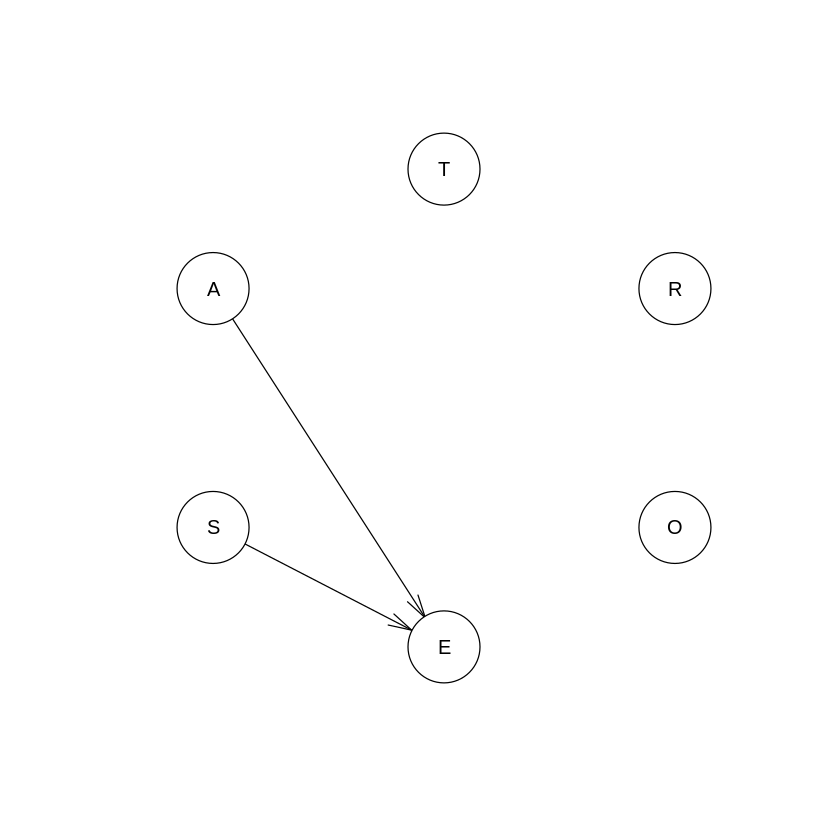

In [8]:
plot(dag)

El nivel de educación tiene una fuerte influencia en la ocupación del individuo, así como en su lugar de residencia:

In [9]:
dag <- set.arc(dag, from = "E", to = "O")
dag <- set.arc(dag, from = "E", to = "R")

Finalmente, los medios de transporte preferidos por el individuo están directamente influidos por su lugar de residencia y su ocupación. En cuanto al primer factor, la distancia al lugar de trabajo desde la residencia influye directamente en la opción de transporte. Por otra parte, algunos trabajos requieren viajes periódicos de larga distancia, mientras que otros requieren trayectos más frecuentes sobre cortas distancias.

In [10]:
dag <- set.arc(dag, from = "R", to = "T")
dag <- set.arc(dag, from = "O", to = "T")

Finalmente, asi queda definido el grafo:

In [11]:
dag


  Random/Generated Bayesian network

  model:
   [A][S][E|A:S][O|E][R|E][T|O:R] 
  nodes:                                 6 
  arcs:                                  6 
    undirected arcs:                     0 
    directed arcs:                       6 
  average markov blanket size:           2.67 
  average neighbourhood size:            2.00 
  average branching factor:              1.00 

  generation algorithm:                  Empty 


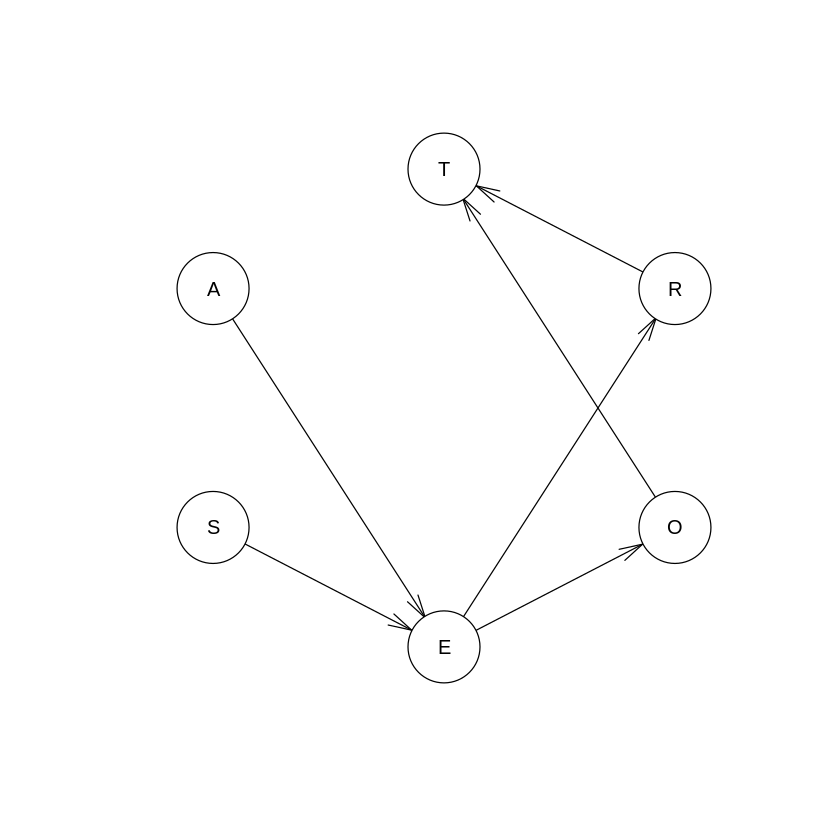

In [12]:
plot(dag)

Esta es la definición simbólica del grafo:

In [13]:
modelstring(dag)

[1] "[A][S][E|A:S][O|E][R|E][T|O:R]"

De este modo, las dependencias de cada variable quedan definidas por una barra vertical (`|`) y separadas por dos puntos `:`. Por ejemplo, `[E|A:S]` significa que `A --> E` (_edad influye sobre empleo_) y `S --> E` (_sexo influye sobre empleo_). Esta notación se asemeja a un producto de probabilidades condicionales, del tipo $P(E|A,S)$. Esto equivale a la expresión de la factorización de la distribución global hecha por nuestra red (Eq. 1):

$$P(A,S,E,O,R,T) = P(A)P(S)P(E|A,S)P(O|E)P(R|E)P(T|O,R)$$

Otras funciones útiles para explorar objetos de la clase `bn` son por ejemplo `nodes`y `arcs`:

In [14]:
nodes(dag)

[1] "A" "S" "E" "O" "R" "T"

In [15]:
arcs(dag)

from,to
A,E
S,E
E,O
E,R
R,T
O,T


#### 2.1.1 Forma alternativa para dibujar el DAG de forma más directa

La función `arcs` es especialmente interesante ya que nos permite añadir arcos de manera más rápida. En este caso, se podrían definir las relaciones mediante una matriz de dos columnas similar a la devuelta por `arcs`:

In [16]:
dag2 <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

In [17]:
arc.set <- matrix(c("A", "E",
                    "S", "E",
                    "E", "R",
                    "E", "O",
                    "O", "T",
                    "R", "T"),
                  byrow = TRUE, ncol = 2,
                  dimnames = list(NULL, c("from", "to")))

In [18]:
arcs(dag2) <- arc.set

El grafo resultante es idéntico al que se generó anteriormente:

In [19]:
all.equal(dag, dag2)

[1] TRUE

Ambas formas de definir el grafo garantizan que éste sea acíclico, ya que si se intenta introducir un ciclo en el mismo se producirá un error. Por ejemplo, si intentamos crear una relación directa entre `T` y `E`, lo que daría lugar a un ciclo, se produce un error:

```r
try(set.arc(dag, from = "T", to = "E"))
```

```
## Error in arc.operations(x = x, from = from, to = to, op = "set", check.cycles = check.cycles,  : 
##   the resulting graph contains cycles.
```

### 2.2 Representacion probabilística de la red Bayesiana

#### 2.2.1 Definición de los estados de las variables

Una vez representadas las interacciones entre variables mediante el grafo, es necesario especificar una distribución de probabilidad conjunta sobre todas las variables para obtener el modelo bayesiano de los datos de la encuesta. Todas ellas, como se dijo al principio, son variable discretas y definidas para una serie de estados ordenados (categorías, o `levels` en R), que se definen a continuación:

In [20]:
estados.A <- c("young", "adult", "old")
estados.S <- c("M", "F")
estados.E <- c("high", "uni")
estados.O <- c("emp","self")
estados.R <- c("small","big")
estados.T <- c("car","train","other")

En este caso, la distribución de probabilidad conjunta viene dada por una distribución multinomial (ver `help("dmultinom")` para más detalles), asignando una probabilidad a cada una de las combinaciones de los posibles estados de las variables de la encuesta. Es lo que denominamos la *distribución global*.

El problema, como se ha visto anteriormente, surge del hecho de que usar la distribución global directamente es difícil (cuando no completamente inviable), debido al gran número de parámetros a la que puede dar lugar. En este caso particular, considerar la distribución global daría lugar a $3 * 2 * 2 * 2 * 2 * 3 - 1$ parámetros, es decir 143 probabilidades correspondientes a todas las posibles combinaciones de los niveles de todas las variables. En su lugar, hemos utilizado un  modelo mucho más parsimonioso a partir del grafo, descartando muchas relaciones entre variables que sabemos *a priori* que no tienen sentido (p. ej. la relación entre la edad `A` y el sexo `S` del encuestado). Las variables que no se encuentran unidas por ningún arco se dice que son *condicionalmente independientes*. Por lo tanto, la factorización representada por la ecuación 1.1. es un submodelo de la distribución global que contiene muchos menos parámetros.

#### 2.2.2 Definición de probabilidades

Dado que las probabilidades condicionales pueden ser unidimensionales o venir en forma de tablas de varias dimensiones dependiendo del número de padres de cada nodo, utilizaremos para crear dichas probabilidades la función `array`, que permite utilizar una interfaz común en todos los casos. Nótese no obstante que para probabilidades unidimensionales (variables sin padres) o para tablas de dos dimensiones (variables con un padre) puede utilizarse alternativamente la función `matrix`. A continuación veremos ejemplos.

En la encuesta, la Edad y el Sexo vienen dadas por probabilidades unidimensionales, ya que son variables que no tienen *padres* en el grafo. 

In [21]:
A.prob <- array(c(.3, .5, .2), dim = 3, dimnames = list(A = estados.A))
print(A.prob)

A
young adult   old 
  0.3   0.5   0.2 


In [22]:
S.prob <- array(c(.6, .4), dim = 2, dimnames = list(S = estados.S))
print(S.prob)

S
  M   F 
0.6 0.4 


Ocupación y residencia, al depender de Educación, se representan mediante una tabla de probabilidades condicionadas de dos dimensiones. Cada columna en este caso representa cada uno de los niveles del padre, y mantiene la distribución de la variable condicionada cada nivel particular, por lo que las probabilidades de 
cada columna siempre suman 1:

In [23]:
O.prob <- array(c(.96,.04,.92,.08), dim = c(2,2), 
                  dimnames = list(O = estados.O, E = estados.E))
print(O.prob)

      E
O      high  uni
  emp  0.96 0.92
  self 0.04 0.08


In [24]:
R.prob <- array(c(.25,.75,.2,.8), dim = c(2,2), 
                  dimnames = list(R = estados.R, E = estados.E))
print(R.prob)

       E
R       high uni
  small 0.25 0.2
  big   0.75 0.8


Por último, Educación y Transporte se modelizan en forma de tablas 3-dimensionales, dado que tienen 2 padres cada una. Cada columna corresponde en este caso a una combinación de los niveles de los padres y contienen la probabilidad de la variable condicionada a esa combinación particular:

In [25]:
# Tabla de probabilidades condicionales para el nodo Educacion
E.prob <- array(c(.75, .25, .72, .28, .88, .12, .64, .36, .70, .30, .90, .10),
                dim = c(2, 3, 2),
                dimnames = list(E = estados.E,
                                A = estados.A,
                                S = estados.S))
print(E.prob)

, , S = M

      A
E      young adult  old
  high  0.75  0.72 0.88
  uni   0.25  0.28 0.12

, , S = F

      A
E      young adult old
  high  0.64   0.7 0.9
  uni   0.36   0.3 0.1



In [26]:
# Tabla de probabilidades condicionales para el nodo Transporte
T.prob <- array(c(.48, .42, .1, .56, .36, .08, .58, .24, .18, .7, .21, .09),
                dim = c(3,2,2),
                dimnames = list(T = estados.T, 
                                O = estados.O,
                                R = estados.R))
print(T.prob)

, , R = small

       O
T        emp self
  car   0.48 0.56
  train 0.42 0.36
  other 0.10 0.08

, , R = big

       O
T        emp self
  car   0.58 0.70
  train 0.24 0.21
  other 0.18 0.09



Una vez definidos el grafo y la distribución de las probabilidades locales de cada variable, se combinan para crear la red bayesiana propiamente dicha. Para ello, se almacenan las diferentes tablas de probabilidades condicionadas en una lista (`named list` en R), en la que cada elemento lleva el nombre la variable correspondiente (la llamamos `cpt`, de _conditional probability tables_):

In [27]:
cpt <- list(A = A.prob, S = S.prob, E = E.prob, O = O.prob, R = R.prob, T = T.prob)
str(cpt)

List of 6
 $ A: num [1:3(1d)] 0.3 0.5 0.2
  ..- attr(*, "dimnames")=List of 1
  .. ..$ A: chr [1:3] "young" "adult" "old"
 $ S: num [1:2(1d)] 0.6 0.4
  ..- attr(*, "dimnames")=List of 1
  .. ..$ S: chr [1:2] "M" "F"
 $ E: num [1:2, 1:3, 1:2] 0.75 0.25 0.72 0.28 0.88 0.12 0.64 0.36 0.7 0.3 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ E: chr [1:2] "high" "uni"
  .. ..$ A: chr [1:3] "young" "adult" "old"
  .. ..$ S: chr [1:2] "M" "F"
 $ O: num [1:2, 1:2] 0.96 0.04 0.92 0.08
  ..- attr(*, "dimnames")=List of 2
  .. ..$ O: chr [1:2] "emp" "self"
  .. ..$ E: chr [1:2] "high" "uni"
 $ R: num [1:2, 1:2] 0.25 0.75 0.2 0.8
  ..- attr(*, "dimnames")=List of 2
  .. ..$ R: chr [1:2] "small" "big"
  .. ..$ E: chr [1:2] "high" "uni"
 $ T: num [1:3, 1:2, 1:2] 0.48 0.42 0.1 0.56 0.36 0.08 0.58 0.24 0.18 0.7 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ T: chr [1:3] "car" "train" "other"
  .. ..$ O: chr [1:2] "emp" "self"
  .. ..$ R: chr [1:2] "small" "big"


Y se crea la red bayesiana con la función `custom.fit`:

In [28]:
bn <- custom.fit(dag, cpt)

El objeto `bn` es la red bayesiana completa (grafo + tablas de probabilidad asociadas a cada nodo).

### 2.3 Extraer propiedades básicas del grafo 

#### 2.3.1 Número de parámetros de la factorización

Como se dijo anteriormente, el número de parámetros (21) de la red es mucho menor que el de la distribución de probabilidades global, que era de 143.

In [29]:
bnlearn::nparams(bn)

[1] 21

#### 2.3.2 Arcos, nodos y estructuras gráficas

Del objeto resultante que contiene la definición de la red bayesiana pueden extraerse diversos parámetros referentes a la estructura del grafo, además de los arcos, `arcs`, que ya hemos visto anteriormente. 

In [30]:
# Arcos
bnlearn::arcs(bn)

from,to
A,E
S,E
E,O
E,R
O,T
R,T


In [31]:
# Nodos
bnlearn::nodes(bn)

[1] "A" "S" "E" "O" "R" "T"

In [33]:
# Padres de un determinado nodo
bnlearn::parents(bn, "E")

[1] "A" "S"

In [34]:
bnlearn::parents(bn, "A")

character(0)

In [35]:
# Hijos
bnlearn::children(bn, "A")

[1] "E"

#### 2.3.3 Orden

A menudo, si consideramos la red bayesiana como un modelo causal, nos puede interesar conocer el orden topológico de los nodos. La posición relativa de dos nodos dentro de la topología red es indicativa de la dirección de una posible relación causal entre ellos, porque implica la dirección de cualquier posible conexión entre ellos:

In [36]:
node.ordering(dag)

[1] "A" "S" "E" "O" "R" "T"

### 2.3.4 Vecindad y manta de Markov

La vecindad (_neighborhood_, `nbr`) y la Markov blanket (`mb`) de un nodo proporciona una descripción sintética de la estructura de dependencia local alrededor de un nodo. 

Así, la _manta de Markov_ de un nodo es el conjunto de los nodos vecinos: sus padres, sus hijos y otros padres de sus hijos. X es una red bayesiana con respecto a G si cada nodo es condicionalmente independiente de todos los demás nodos de la red, dada su manta Markov. 

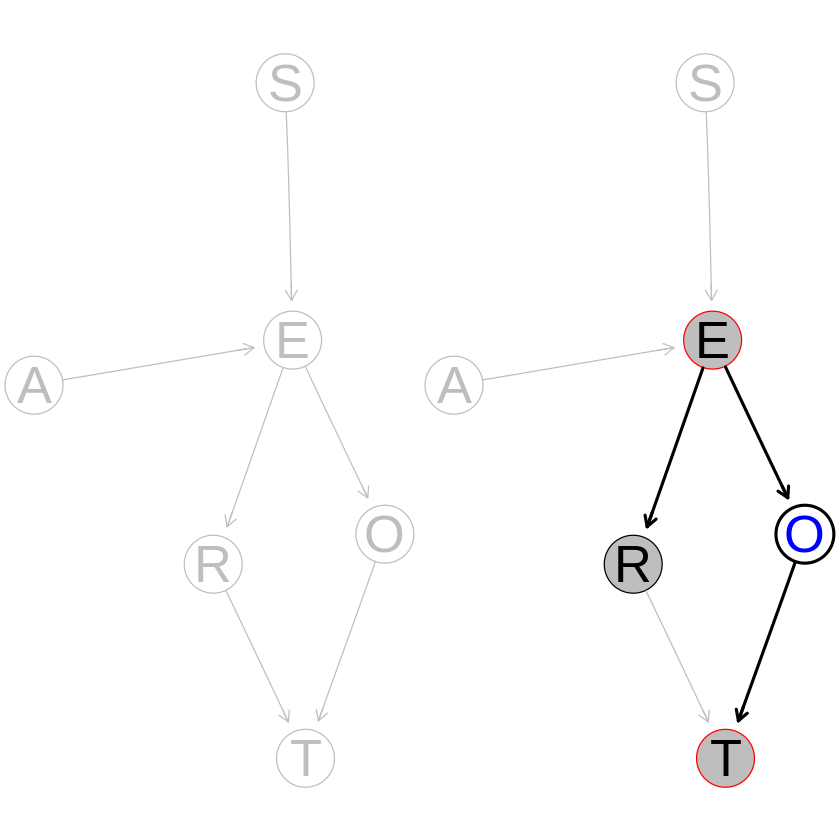

In [37]:
#::GMG::Manta de Markov del nodo \'O\' de la red bayesiana, indicada por los nodos 
#       en gris. La vecindad de \'O\' está representada por los nodos con bordes rojos.
par(mfrow = c(1,2))        
hlight <- list(nodes = nodes(dag), arcs = arcs(dag), col = "grey", textCol = "grey")
pp <- graphviz.plot(dag, highlight = hlight, layout = "circo")
edgeRenderInfo(pp) <- list(col = c("E~O" = "black", "O~T" = "black", "E~R" = "black"),
                           lwd = c("E~O" = 2.5, 
                                   "E~R" = 2.5, 
                                   "O~T" = 2.5)) # grosor
nodeRenderInfo(pp) <- list(col = c("E" = "red", "R" = "black", "T" = "red", "O" = "black"),
                           textCol = c("E" = "black", 
                                       "R" = "black", 
                                       "T" = "black", 
                                       "O" = "blue"),
                           fill = c("E" = "grey", "R" = "grey", "T" = "grey"),
                           lwd = c("O" = 2.5))
renderGraph(pp)

Se obtiene esta información con los comandos `nbr` (*neighbourhood*)

In [38]:
nbr(dag, "O")

[1] "E" "T"

y `mb` (*markov blanket*):

In [39]:
mb(dag, "O")

[1] "E" "R" "T"

También podemos utilizar los comandos anteriores para mostrar que ambos sets describen una relación simétrica, por ejemplo, si `R` está en la manta de Markov de `O`, `O` estará en la de `R`:

In [40]:
"R" %in% mb(dag, "O")

[1] TRUE

In [41]:
"O" %in% mb(dag, "R")

[1] TRUE

In [42]:
#::GMG::Aquí me pregunto cual es el mb de R
mb(dag, "R")

[1] "E" "O" "T"

In [43]:
nbr(x = dag, node = "R")

[1] "E" "T"

Además, podemos verificar fácilmente como la Markov blanket de un nodo cualquiera (`O` en este ejemplo), está compuesta por sus hijos (objeto `child`), sus padres (objeto `par`), y los otros padres de sus hijos (objeto `o.par`), por su propia definición:

In [44]:
child <- bnlearn::children(dag, "O")
par <- bnlearn::parents(dag, "O")
o.par <- sapply(child, bnlearn::parents, x = dag)
unique(c(par, child, o.par[o.par != "O"]))

[1] "E" "T" "R"

In [45]:
mb(dag, "O")

[1] "E" "R" "T"

#### 2.3.5 Estructuras en V

Como se ha visto anteriormente, existen en esencia tres tipos de triplos permitidos en un DAG:

1. $X \rightarrow Y \rightarrow Z$ (Estructura *en cascada*)
2. $X \leftarrow Y \rightarrow Z$ (*Padre en común*)
3. $X \rightarrow Y \leftarrow Z$ (*Estructura en V*)

Las dos primeras estructuras codifican esencialmente la misma *d-separación*, ya que los nodos $X$ y $Z$ con condicionalmente independientes dado $Y$ (se suele decir que $Y$ "bloquea" la unión entre $X$ y $Z$). En el caso (3), sin embargo, si no se da $Y$, los nodos $X$ y $Z$ son independientes.

A continuación se muestra cada uno de los casos para la red creada. El caso 1:

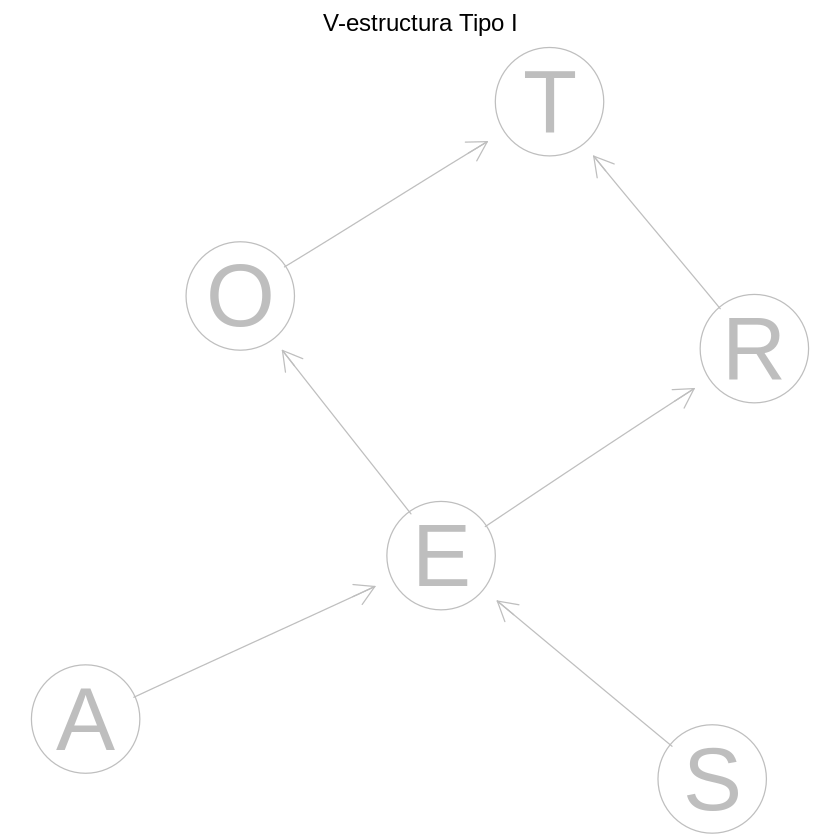

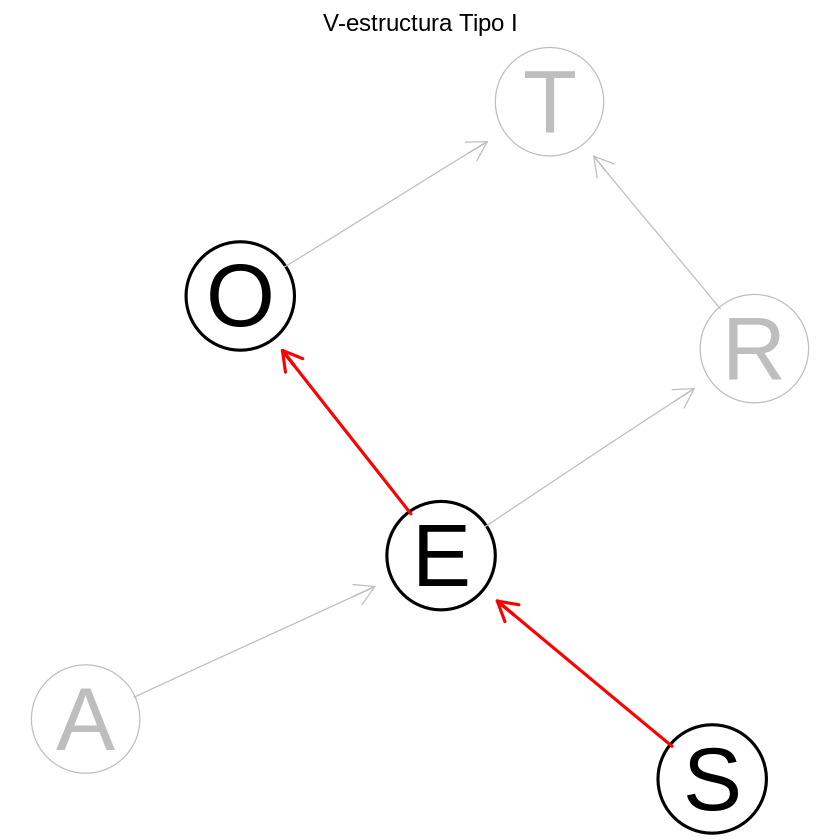

In [50]:
hlight <- list(nodes = nodes(dag), arcs = arcs(dag), col = "grey", textCol = "grey")
pp <- graphviz.plot(dag, highlight = hlight,
                    layout = "neato", main = "V-estructura Tipo I")
edgeRenderInfo(pp) <- list(col = c("S~E" = "red", "E~O" = "red"),
                           lwd = c("S~E" = 2.5, "E~O" = 2.5)) # grosor
nodeRenderInfo(pp) <- list(col = c("E" = "black", "S" = "black", "O" = "black"),
                           textCol = c("E" = "black", "S" = "black", "O" = "black"),
                           lwd = c("E" = 2.5, "S" = 2.5, "O" = 2.5))
renderGraph(pp)

En el caso (2) sucede algo similar:

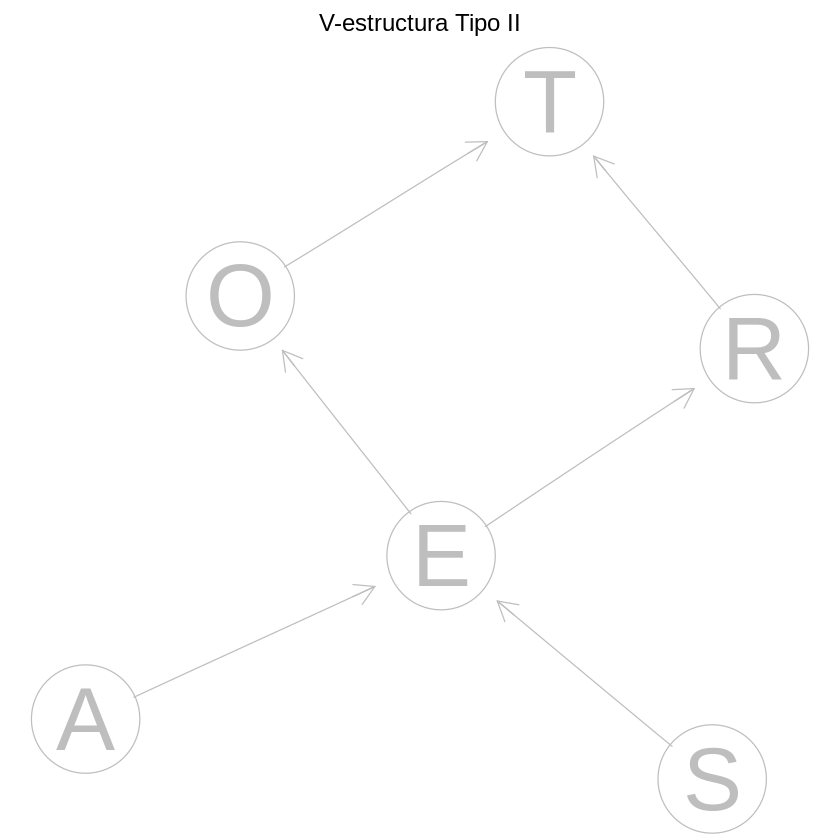

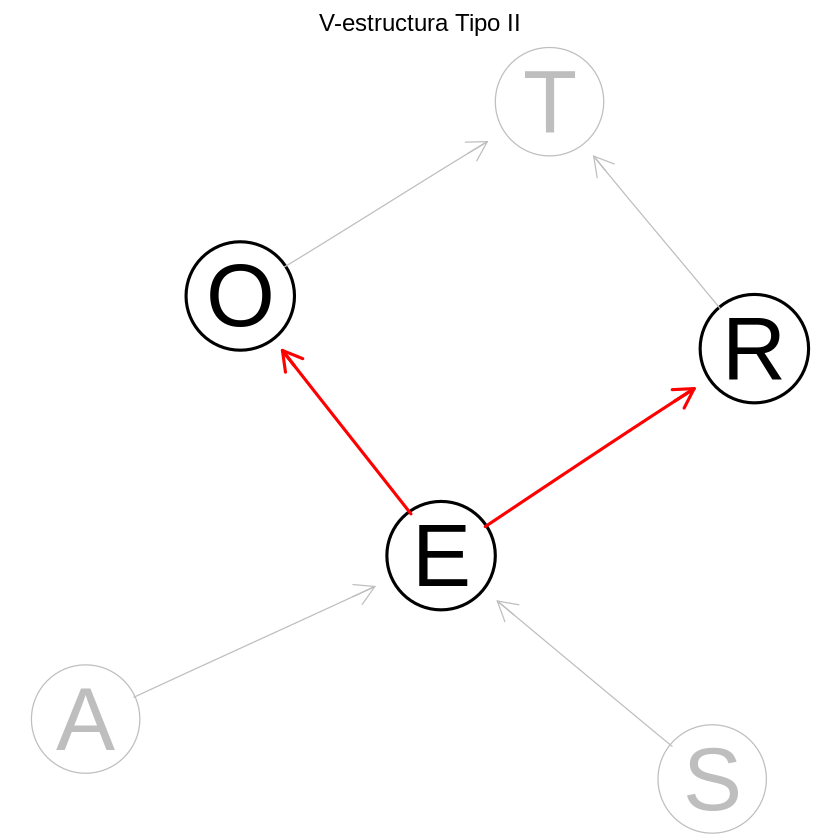

In [47]:
pp <- graphviz.plot(dag, highlight = hlight,
                    layout = "neato", main = "V-estructura Tipo II")
edgeRenderInfo(pp) <- list(col = c("E~R" = "red", "E~O" = "red"),
                           lwd = c("E~R" = 2.5, "E~O" = 2.5)) # grosor
nodeRenderInfo(pp) <- list(col = c("E" = "black", "R" = "black", "O" = "black"),
                           textCol = c("E" = "black", "R" = "black", "O" = "black"),
                           lwd = c("E" = 2.5, "R" = 2.5, "O" = 2.5))
renderGraph(pp)

En el caso (3), se tiene un *estructura en V*. La `E` y `S` son a priori independientes, pero pasan a ser dependientes conocido `E`.

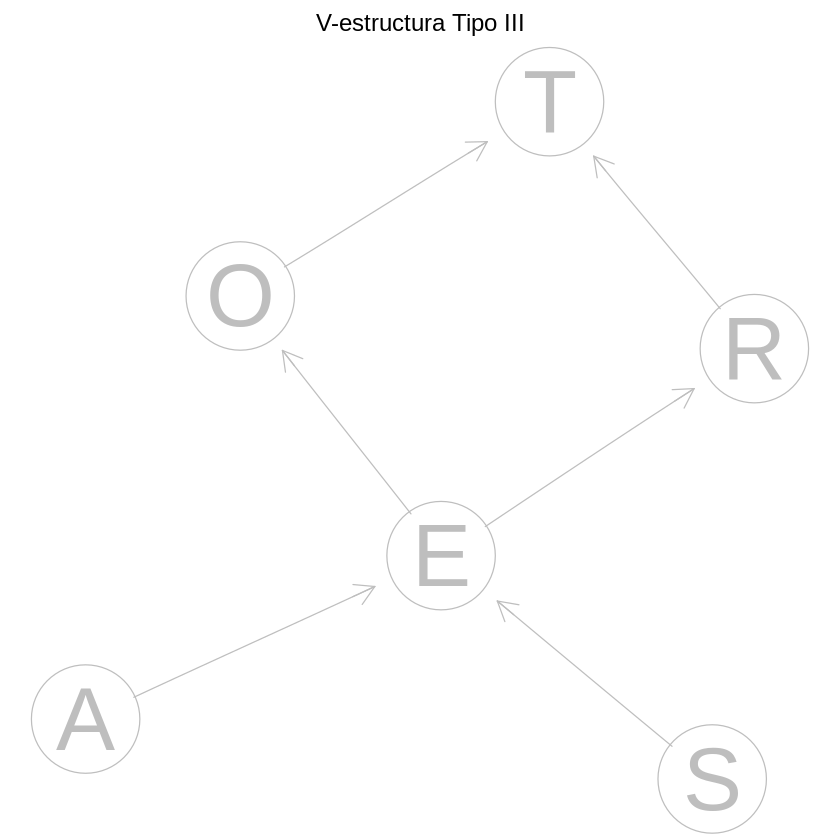

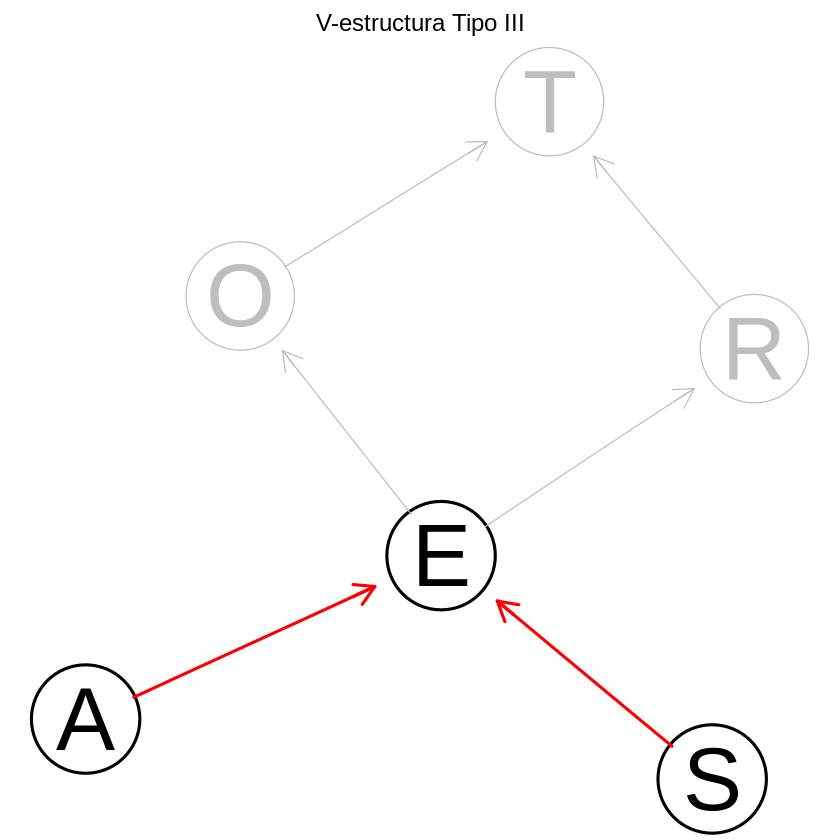

In [48]:
pp <- graphviz.plot(dag, highlight = hlight,
                    layout = "neato", main = "V-estructura Tipo III")
edgeRenderInfo(pp) <- list(col = c("S~E" = "red", "A~E" = "red"),
                           lwd = c("S~E" = 2.5, "A~E" = 2.5)) # grosor
nodeRenderInfo(pp) <- list(col = c("E" = "black", "S" = "black", "A" = "black"),
                           textCol = c("E" = "black", "S" = "black", "A" = "black"),
                           lwd = c("E" = 2.5, "S" = 2.5, "A" = 2.5))
renderGraph(pp)

El comando `vstructs` sirve para comprobar la _v-estructuras_ presentes en el grafo (es decir, aquellas estructuras convergentes en las que un nodo tiene dos padres):

In [51]:
bnlearn::vstructs(dag)

X,Z,Y
A,E,S
O,T,R


En este caso, tanto `A-E-S` como `O-T-R` forman _v-estructuras_. 

#### 2.3.6 Matriz de adyacencia

También podemos obtener la _matriz de adyacencia_ de forma directa con `amat`, que es otro modo de especificar las uniones entre nodos:

In [52]:
bnlearn::amat(dag)

,A,S,E,O,R,T
A,0,0,1,0,0,0
S,0,0,1,0,0,0
E,0,0,0,1,1,0
O,0,0,0,0,0,1
R,0,0,0,0,0,1
T,0,0,0,0,0,0


De hecho, dado un conjunto de nodos y la matriz de adyancencia (que podría contruirse a mano o ser importada desde otro formato), es posible definir un DAG completamente:

In [53]:
mat <- amat(dag)
dag3 <- empty.graph(nodes(dag))
amat(dag3) <- mat

In [54]:
all.equal(dag, dag3)

[1] TRUE

#### 2.3.7 Obtención de las tablas de probabilidad

Las tablas de probabilidades condicionadas se pueden obtener a partir del objeto `bn` de forma directa:

In [55]:
bn$O


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O      high  uni
  emp  0.96 0.92
  self 0.04 0.08

In [56]:
coef(bn$O)

      E
O      high  uni
  emp  0.96 0.92
  self 0.04 0.08

Del mismo modo, simplemente introduciendo `bn` se obtiene el conjunto de todas las tablas de probabilidad:

In [57]:
print(bn)


  Bayesian network parameters

  Parameters of node A (multinomial distribution)

Conditional probability table:
 A
young adult   old 
  0.3   0.5   0.2 

  Parameters of node S (multinomial distribution)

Conditional probability table:
 S
  M   F 
0.6 0.4 

  Parameters of node E (multinomial distribution)

Conditional probability table:
 
, , S = M

      A
E      young adult  old
  high  0.75  0.72 0.88
  uni   0.25  0.28 0.12

, , S = F

      A
E      young adult  old
  high  0.64  0.70 0.90
  uni   0.36  0.30 0.10


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O      high  uni
  emp  0.96 0.92
  self 0.04 0.08

  Parameters of node R (multinomial distribution)

Conditional probability table:
 
       E
R       high  uni
  small 0.25 0.20
  big   0.75 0.80

  Parameters of node T (multinomial distribution)

Conditional probability table:
 
, , R = small

       O
T        emp self
  car   0.48 0.56
  train 0.42 0.36
  other 0.10 0.08

## 3 Inferencia

La utilidad de la red probabilística radica en último término hallar de forma eficiente la probabilidad de cualquier nodo (o conjunto de nodos), dada una cierta información (*evidencia*). Este proceso se denomina *inferencia* o razonamiento probabilístico. Una red bayesiana puede utilizarse para hacer inferencia bien a través de su DAG, o través del conjunto de distribuciones locales definido. Básicamente, el tipo de cuestiones que podemos plantearle a nuestra red bayesiana, como si de un sistema experto se tratara, son tres tipos:

1. Las probabilidades de que ocurra un evento bajo unas circunstancias específicas, es decir, _consultas de probabilidad condicionada_
2. Validar la asociación entre dos variables una vez que la influencia de una tercera es descartada, es decir, _consultas de independencia condicional_
3. Identificar el estado más probable de una o más variables, lo cual lleva a la _explicación más probable_.

### 3.1 Inferencia a partir de la estructura del DAG: _d-separación_

Podemos estudiar la asociación entre variables con la información contenida en nuestro grafo, almacenado en el objeto `dag`, mediante una consulta de probabilidad condicionada. Esto es posible mediante un análisis entre las conexiones del DAG, para comprobar si existe alguna conexión entre ellas, bien sea directa o indirecta, dependiendo de si la relación entre las dos variables está mediada por uno o más arcos respectivamente. Si no existe dicha conexión entre las variables en el grafo, hablamos de separación dirigida, o _d-separación_. Los detalles de la d-separación ya se han visto anteriormente. En esta práctica, basta con recordar que la separación gráfica de dos variables ($\perp_{G}$) implica independencia probabilística ($\perp_{P}$) en la red bayesiana. Si todas las trayectorias entre $X$ e $Y$ se encuentran bloqueadas, se dice que $X$ e $Y$ son (condicionalmente) independientes dada una tercera variable $Z$, lo que representamos como $X \perp_{G} Y | Z$. Lo contrario no es necesariamente cierto: no todas las relaciones de independencia condicional se encuentran reflejadas en el grafo.

Podemos investigar la d-separación entre variables de un grafo con la función `dsep`:

In [105]:
dsep(dag, x = "S", y = "R")

[1] FALSE

In [106]:
dsep(dag, x = "O", y = "R")

[1] FALSE

En los anteriores ejemplos las variables introducidas no son independientes. Esto podemos verlo en el grafo, donde el sexo (`S`) y el lugar de residencia (`R`) están conectados a través de educación (`E`). Del mismo modo, la ocupación (`O`) y el lugar de residencia están relacionadas a través de la educación (`E`).

De hecho, podemos comprobar que hay una conexión entre `S` y `R` el el DAG:

In [107]:
bnlearn::path(dag, from = "S", to = "R")

[1] TRUE

pero si condicionamos a la educación, la conexión queda bloqueada y `S` y `R` son ahora independientes:

In [108]:
dsep(dag, x = "S", y = "R", z = "E")

[1] TRUE

Lo mismo aplica a la relación entre `O` y `R`. Ambas dependen de `E`, y por lo tanto ambas se vuelven independientes cuando condicionamos sobre `E`:

In [109]:
dsep(dag, "O", "R", "E")

[1] TRUE

Por el contrario, condicionar sobre un nodo particular puede también hacer que otros nodos marginalmente independientes pasen a ser dependientes. Por ejemplo, 

In [110]:
dsep(dag, x = "A", y = "S")

[1] TRUE

In [111]:
dsep(dag, x = "A", y = "S", z = "E")

[1] FALSE

Efectivamente, si queremos hacer inferencia sobre el nodo `A` en este caso, necesitaremos además información sobre los nodos `S` y `E`. Este subconjunto de nodos constituye el _Markov blanket_ de `A`, siendo el resto de los nodos del grafo redundantes para hacer inferencia sobre `A`:

In [112]:
mb(dag, "A")

[1] "S" "E"

Sabemos a partir del grafo que el estado de `E` esta influenciado por los estados de `A` y `S`, que son sus padres.

In [113]:
bnlearn::parents(dag, "E")

[1] "A" "S"

A su vez, `A` y `S` pasan a ser dependientes dado `E`. De forma equivalente, `E` depende de la distribución conjunta de `A` y `S`, $P(\mathrm{\texttt{E|A,s}})$; por tanto, de acuerdo con el Teorema de Bayes, tenemos:

$$
\begin{aligned}
P(\mathrm{\texttt{E|A,S}}) = \frac{P(\mathrm{\texttt{A,S,E}})}{P(\mathrm{\texttt{A,S}})} = \frac{P(\mathrm{\texttt{A,S|E}})P(\mathrm{\texttt{E}})}{P(\mathrm{\texttt{A}})P(\mathrm{\texttt{S}})} \alpha P(\mathrm{\texttt{A,S|E}})
\end{aligned}
$$

, y por lo tanto cuando `E` es conocida, no podemos descomponer la probabilidad conjunta de `A` y `S` en una parte que dependa sólo de `A` y otra de `S`. No obstante, $P(\mathrm{\texttt{A,S}}) = P(\mathrm{\texttt{A|S}})P(\mathrm{\texttt{S}}) = P(\mathrm{\texttt{A}})P(\mathrm{\texttt{S}})$: tal y como se ha visto en el ejemplo anterior, `A` y `S` están d-separadas cuando no se condiciona a `E`.

Estos tres ejemplos de relaciones condicionadas entre variables recogen las tres configuraciones básicas de tres nodos y dos arcos. Se conocen como _conexiones fundamentales_ y son los bloques sobre los que se fundamentan las propiedades gráficas y probabilísticas de las redes bayesianas. Puedes repasar las diapositivas de la parte teórica, pero simplemente para fijar conceptos, estas son las tres conexiones fundamentales:

* Conexiones en serie (cascada): del tipo: `S -> E -> R`, como en el primer ejemplo
* Conexiones divergentes (padre en común): del tipo: `R <- E -> O`, como en el segundo ejemplo
* Conexiones convergentes (v-estructuras): del tipo `A -> E <- S`, como en el tercer ejemplo. Forman las llamadas _estructuras en V_

### Ejercicio 1

A continuación, basándote en el concepto de d-separación y utilizando únicamente la información representada en el grafo, intenta responder a las siguientes preguntas:

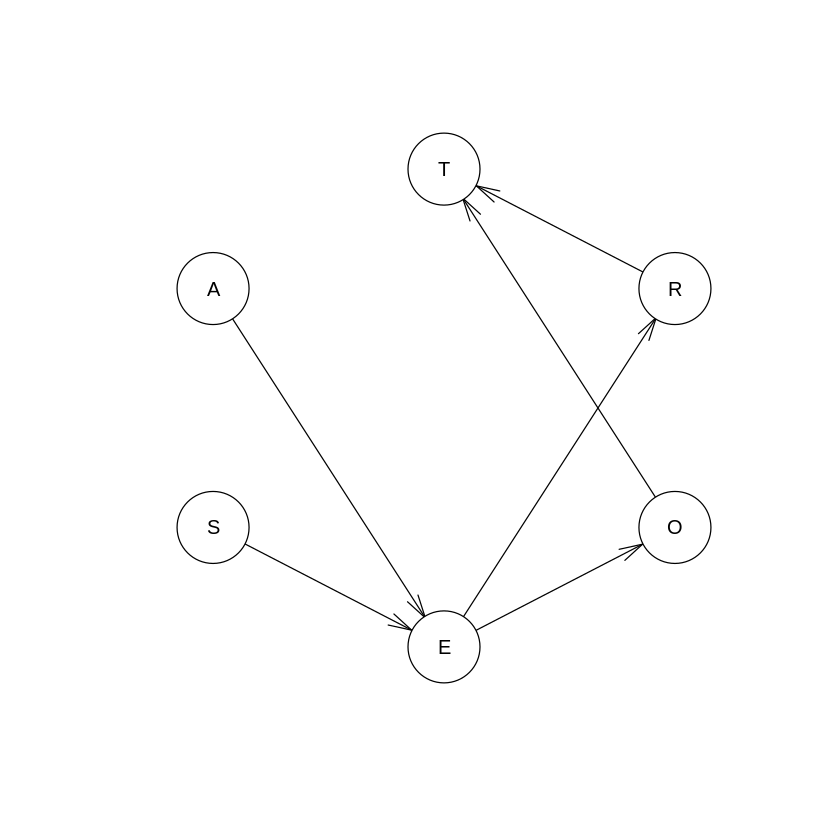

In [114]:
plot(dag)

1. Evaluar la dependencia entre edad y sexo ¿son independientes?

In [115]:
dsep(dag, x = "A", y = "S")

[1] TRUE

2. Ahora evalúa lo mismo conocido el nivel educativo ¿como es ahora su relación?

In [116]:
dsep(dag, x = "A", y = "S", z = "E")

[1] FALSE

3. A continuación evalúa la dependencia entre ambas variables pero conociendo sólo el medio de transporte elegido.

In [117]:
dsep(dag, x = "A", y = "S", z = "T")

[1] FALSE

4. A continuación evalúa de nuevo la dependencia entre ambas variables pero conociendo sólo el lugar de residencia.

In [118]:
dsep(dag, x = "A", y = "S", z = "R")

[1] FALSE

### 3.2 Inferencia a partir de las tablas de probabilidades condicionales

Consultas a nuestro "sistema experto" un poco más complejas requieren la utilización de las tablas de probabilidades condicionales contenidas en nuestra red bayesiana. En este contexto, las variables utilizadas como condiciones en nuestro sistema constituyen las nuevas _evidencias_ que nosotros introducimos, y a partir de las cuales se re-calculan las probabilidades de los eventos sobre los que nos interesa obtener información.

Hay dos tipos de inferencia: _exacta_ y _aproximada_. La primera nos proporciona valores más precisos, y resulta computacionalmente mucho más barata de calcular que la estimada, que se basa en generar multitud de datos aleatorios mediante un test de permutación de Monte-Carlo. 

**::NOTA::**: La inferencia aproximada está implementada en el paquete `bnlearn` a través de las funciones `cpquery` and `cpdist`, cuya ayuda proporciona información adicional sobre esta aproximación al problema de la inferencia.

#### 3.2.1 Inferencia exacta

La inferencia exacta está implementada en el paquete `gRain` (**gRa**phical **in**ference), que transforma la red bayesiana en un árbol que acelera los cálculos de la probabilidades condicionadas (algoritmo *junction tree*, o *árbol de cliques*, que se ha visto durante anteriores sesiones).

Recordemos que el árbol de cliques se construía a partir de la _moralización_ del DAG. El grafo _moral_ es de tipo no dirigido (conocido como red de Markov), que se construye a partir del DAG a través de dos pasos:

1. Conectando los nodos no adyacentes de cada _v-estructura_ con un arco no dirigido (vértice).
2. Ignorando la dirección del resto del arcos del DAG, y por tanto sustituyéndolos por vértices.

A la transformación (1) se la denomina _moralización_, porque "casa" a padres no-adyacentes que comparten un hijo. La función `moral` realiza la moralización de un DAG de forma directa:

In [119]:
mdag <- moral(dag)

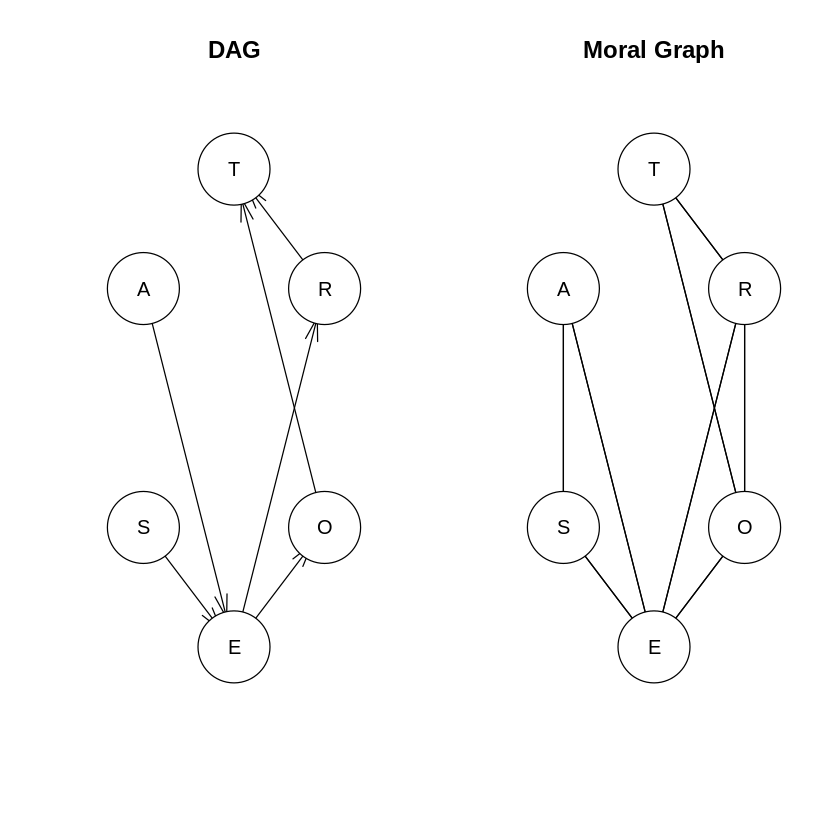

In [120]:
par(mfrow = c(1,2))
plot(dag, main = "DAG")
plot(mdag, main = "Moral Graph")

Como se vió en la parte teórica, este paso es primordial para la generación del árbol de cliques, necesario para realizar la inferencia exacta. Sin embargo, no es necesario realizar todo el proceso de moralización y generación de cliques. La construcción de dicho árbol es inmediata a partir del objeto `bn` usando la función `compile` sobre un objeto de tipo `grain` implementado en la librería `gRain`:

In [121]:
#library(gRain)
junction <- compile(as.grain(bn))

Una vez creado el árbol (`as.grain`), y las tablas de probabilidad calculadas (`compile`), podemos introducir la nueva evidencia. Las distribuciones locales en cada nodo se actualizan en base a la nueva información introducida, que se propaga a lo largo del árbol. La consulta es realizada a través de la función `querygrain`, que calcula la distribución en los nodos que nos interesan del objeto `junction`.

Por ejemplo, podríamos estar interesados en las actitudes del público femenino respecto al uso del tren o el coche en comparación con la muestra completa de todos los encuestados:

In [122]:
# Esta es la probabilidad marginal de T:
print(querygrain(junction, nodes = "T")$T)

T
      car     train     other 
0.5618340 0.2808573 0.1573088 


In [123]:
# Introducimos la nueva evidencia
jsex <- setEvidence(junction, nodes = "S", states = "F")
# Nueva probabilidad marginal dada la evidencia
print(querygrain(jsex, nodes = "T")$T)

T
      car     train     other 
0.5620577 0.2806144 0.1573280 


Según esto, parece que no hay diferencias significativas en las probabilidades derivadas del objeto `junction` antes y después de la llamada a `setEvidence`. Lo primero puede representarse como $P(\mathrm{\texttt{T}})$, mientras que tras introducir la evidencia hemos calculado $P(\mathrm{\texttt{T | S = F}})$. Esto sugiere que las mujeres tienen una preferencia similar hacia el coche o el tren que el total de los encuestados considerados globalmente.

Otro problema interesante puede ser como vivir en una ciudad pequeña puede afectar el uso del tren o del coche, esto es, $P(\mathrm{\texttt{T | R = small}})$. 

In [124]:
jres <- setEvidence(object = junction, nodes = "R", states = "small")  
print(querygrain(jres, nodes = "T")$T)

T
       car      train      other 
0.48388675 0.41708494 0.09902831 


Ahora la probabilidad asociada con otros medios de transporte (`other`) cae de 0.157 a 0.099 mientras que la probabilidad asociada a `train` se incrementa de 0.281 a 0.417. En conjunto, las probabilidad combinada de `car` y `train` sube de 0.843 (del total de la muestra) a 0.901 (para las personas que viven en ciudades pequeñas). Por lo tanto, puede concluirse que en ciudades pequeñas el medio de transporte preferido es el coche, aunque aumenta la preferencia por el tren.

También podemos utilizar las consultas de probabilidades condicionadas para evaluar la _independencia condicional_, tal y como hicimos en la sección anterior usando el grafo y el comando `dsep`. Volvamos a considerar la relación entre `S` y `T`, esta vez condicionada a la evidencia de que `E = "high"`. La probabilidad conjunta de `S` y `T` dado que el nivel de educación sea `high`, representado por la expresión $P(\mathrm{\texttt{S,T | E = high}})$, se calcula nuevamente usando `setEvidence` y `querygrain` del siguiente modo:

In [125]:
jedu <- setEvidence(junction, nodes = "E", states = "high")
SxT.cpt <- querygrain(jedu, nodes = c("S", "T"), type = "joint")
print(SxT.cpt)

   T
S         car     train      other
  M 0.3426644 0.1736599 0.09623271
  F 0.2167356 0.1098401 0.06086729
attr(,"class")
[1] "parray" "array" 


In [126]:
dsep(dag, "S", "T", "E")

[1] TRUE

Por tanto, el argumento `type` define cual de las posibles distribuciones asociadas a cada nodo es devuelta en la consulta. El valor por defecto es `marginal`, que devuelve las probabilidades marginales:

In [128]:
print(querygrain(jedu, nodes = c("S", "T"), type = "marginal"))

$S
S
       M        F 
0.612557 0.387443 

$T
T
   car  train  other 
0.5594 0.2835 0.1571 



Usando `type = joint` obtenemos, como se ha visto, la probabilidad conjunta. Por último, podemos obtener las probabilidades condicionales. En este caso, `querygrain` devuelve la distribución del primer nodo en `nodes` condicionada al resto de nodos en `nodes` (y por supuesto a la evidencia previamente presentada mediante `setEvidence`):

In [129]:
print(querygrain(jedu, c("S", "T"), type = "conditional"))

       S
T              M        F
  car   0.612557 0.387443
  train 0.612557 0.387443
  other 0.612557 0.387443


En este caso la suma de columnas suma 1, porque se calculan condicionadas al valor de `T` en cada caso.

### Ejercicio 2

In [131]:
ev1 <- setEvidence(junction, nodes = c("S", "E", "T"), states = c("M", "high", "car"))

In [132]:
print(querygrain(object = ev1, 
                 nodes = c("S", "T"), 
                 type = "conditional"))

ERROR: Error in tabMarg(qobject, nodes[-1]): 'tab' is not an array


In [ ]:
# 
# 1. Comprueba las probabilidades condicionales dado que `S = M` y `E = high` para cada posible estado de `T`
# 2. Ahora realiza la misma prueba que anteriormente, pero sabiendo que `S = F`
# 3. ¿Qué conclusión podemos extraer a la luz de las probabilidades obtenidas en cada uno de los casos?
# 
# # 1
# jsex.edu <- setEvidence(junction, nodes = c("S", "E"), states = c("M", "high"))
# querygrain(jsex.edu, nodes = c("E","S","T"), type = "conditional")
# 
# # 2
# jsex.edu2 <- setEvidence(junction, nodes = c("S", "E"), states = c("F", "high"))
# querygrain(jsex.edu2, nodes = c("E","S","T"), type = "conditional")
# 
# # 3
# Se puede inferir por tanto que `S`es independiente de `T`condicional a `E`

#### 3.2.2 Inferencia aproximada

El uso de simulaciones de Monte-Carlo constituye una aproximación alternativa al problema de la inferencia, basada en generar observaciones aleatorias a partir de la red bayesiana. Estas observaciones son a su vez utilizadas para estimar las probabilidades condicionales que nos interesen de forma aproximada. 

Este método es caro desde el punto de vista computacional, pero a cambio permite introducir especificaciones de la evidencia más complejas y puede ser preferible en redes complejas. En redes discretas, un método sencillo ampliamente utilizado es el de _rejection sampling_.

De acuerdo con este método, se generan observaciones aleatorias independientes a partir de la red bayesiana. Después, se contabiliza el número de dichas observaciones que coinciden con la evidencia dada por la que estamos condicionando y cuántas observaciones también coinciden con el evento cuya probabilidad queremos estimar; la probabilidad condicional estimada es el ratio entre ésta y aquella.

En `bnlearn`, esta aproximación está implementada a través de las funciones `cpquery` y `cpdist`. `cpquery` devuelve la probabilidad de un evento determinado dada cierta evidencia. Volviendo al primer ejemplo utilizado para ilustrar la inferencia exacta, podemos calcular la primera casilla de la tabla de probabilidades del siguiente modo:

In [133]:
set.seed(1)

In [134]:
cpquery(bn, event = (S == "M") & (T == "car"), evidence = (E == "high"))

[1] 0.3514745

Como puede comprobarse, en este caso la probabilidad estimada difiere ligeramente de la que obtuvimos mediante inferencia exacta (0.3427) calculada con `querygrain`, que era $P(\mathrm{\texttt{S = m, T = car | E = high}}) = 0.3427$.

La probabilidad estimada es cercana a su valor verdadero. Esta precisión puede aumentarse aumentando el número de observaciones aleatorias que se genera (argumento `n`, valor por defecto = 5000). Sin embargo, incrementar la precisión tiene su coste: La consulta requiere más tiempo de cálculo, y su precisión podría seguir siendo baja si la evidencia dada tienen una baja probabilidad. Por ejemplo, generamos un millón de observaciones aleatorias para comprobar que ahora nos acercamos más al valor verdadero:

In [135]:
set.seed(1)

In [136]:
cpquery(bn, event = (S == "M") & (T == "car"), evidence = (E == "high"), n = 1e06)

[1] 0.3421707

Una aproximación mejor es el pesado de verosimilitudes (_likelihood weighting_). Este método se basa en en generar observaciones aleatorias de tal modo que todas ellas coinciden con la evidencia dada, y asigna pesos a cada una de ellas de forma apropiada para calcular las probabilidades condicionales al realizar la consulta. Se puede aplicar este método con el argumento `method = "lw"` desde la función `cpquery`:

In [137]:
set.seed(2)

In [138]:
cpquery(bn, event = (S == "M") & (T == "car"), 
        evidence = list(E = "high"), method = "lw")

[1] 0.3390615

En este caso, la probabilidad estimada (0.3390) se aproxima bastante a la calculada anteriormente de forma exacta (0.3427) sin necesidad de realizar $10^{6}$ simulaciones.

Como ejemplo de una consulta algo más complicada, podemos intentar calcular la probabilidad de que un hombre viaje en coche dado que su nivel educativo sea universitario o bien que sea un adulto, independientemente de su nivel educativo:

$$
\begin{aligned}
P(\mathrm{\texttt{S = M, T = car | \{A = young,E = uni\}}} \cup \mathrm{\texttt{\{A = adult\}}})
\end{aligned}
$$


, que se especificaría mediante `cpquery` del siguiente modo:

In [139]:
set.seed(1)

In [140]:
cpquery(bn, event = (S == "M") & (T == "car"),
        evidence = ((A == "young") & (E == "uni")) | (A == "adult"))

[1] 0.335729

La implementación del método `lw` no es lo suficientemente flexible como para calcular evidencias compuestas como esta; esta limitación existe también para las funciones que realizan la inferencia exacta en el paquete `gRain`. 

La función `cpdist`, con una sintaxis similar a `cpquery`, devuelve un `data.frame` que contienen las observaciones aleatorias para las variables en `nodes` generadas que coinciden con los criterios de la evidencia (`evidence`) dada:

In [141]:
SxT <- cpdist(bn, nodes = c("S", "T"), evidence = (E == "high"))
head(SxT)

S,T
M,train
M,train
M,train
F,train
M,car
M,other


Estas observaciones devueltas por `cpdist` pueden ser utilizadas para otros tipos de inferencia, dando lugar a un método muy versátil. Por ejemplo, podemos calcular la tabla de probabilid conjunta de `S` y `T` dado el nivel `E = "high"` y compararla con la que calculamos utilizando `querygrain` en el ejemplo anterior de inferencia exacta. Para ello, usamos `table` para generar la tabla de contingencia `SxT` y `prop.table` para convertir el conteo en probabilidades, como hemos visto anteriormente en la sección de aprendizaje paramétrico:

In [142]:
prop.table(table(SxT))

   T
S          car      train      other
  M 0.33234421 0.16994875 0.10871325
  F 0.21364985 0.11329916 0.06204478

Como vimos anteriormente, en el grupo con `E="high"`, la combinación más frecuente de sexo y medio de transporte es coche y varón.

## 4 Aprendizaje estructural: determinar la estructura de un grafo a partir de los datos

En la sección anterior hemos asumido un conocimiento *a priori* del diagrama acíclico dirigido y de los parámetros de las distribuciones locales que definen la red bayesiana. En este contexto, la red bayesiana es utilizada como un *sistema experto* que formaliza nuestro conocimiento sobre un determinado campo (en este caso los usuarios de transportes).

Sin embargo, más frecuentemente los parámetros y el grafo de la red son aprendidos (estimados) de manera automática a partir de una muestra observada. A continuación vamos a leer un fichero con los datos de la encuesta. Primero leemos los datos:

In [143]:
survey <- read.table("../data/survey.txt", header = TRUE)
head(survey)

A,R,E,O,S,T
adult,big,high,emp,F,car
adult,small,uni,emp,M,car
adult,big,uni,emp,F,train
adult,big,high,emp,M,car
adult,big,high,emp,M,car
adult,small,high,emp,F,train


In [145]:
str(survey)

'data.frame':	500 obs. of  6 variables:
 $ A: Factor w/ 3 levels "adult","old",..: 1 1 1 1 1 1 1 3 3 2 ...
 $ R: Factor w/ 2 levels "big","small": 1 2 1 1 1 2 1 1 1 1 ...
 $ E: Factor w/ 2 levels "high","uni": 1 2 2 1 1 1 1 2 1 2 ...
 $ O: Factor w/ 2 levels "emp","self": 1 1 1 1 1 1 1 1 1 1 ...
 $ S: Factor w/ 2 levels "F","M": 1 2 1 2 2 1 1 1 2 1 ...
 $ T: Factor w/ 3 levels "car","other",..: 1 1 3 1 1 3 1 3 1 1 ...


El aprendizaje estructural de la red es necesario en muchas ocasiones, por ejemplo cuando nos enfrentamos a sistemas complejos en los que el conocimiento experto puede fallar o simplemente no ser abarcable dada la complejidad de la red (sistemas biológicos, procesos metabólicos...). Tambien el aprendizaje automático de la estructura de la red puede ayudar a comprender mejor qué factores afectan y cuáles no a una determinada variable de interés, cuando este conocimiento no lo tenemos _a priori_ ...

Se trata no obstante de una labor compleja, debido fundamentalmente al gran número de posibles DAGs que potencialmente pueden probarse. En la práctica, existen algoritmos diseñados para este fin que pueden ser de gran utilidad, y que se encuentran implementados en el paquete `bnlearn`. Estos algoritmos se basan en dos tipos de criterios estadísticos: *tests de independecia condicionada* y *network scores*, y se basan en rastrear las posibles configuraciones del grafo que maximizan estos scores. 

Los principales algoritmos de aprendizaje estrcutural implementados en `bnlearn` son lo siguientes:

 * Algoritmos basados en scores globales:
    * tabú (`tabu()`)
    * hill climbing (`hc()`)
 * Algoritmos basados en tests de independencia (*contraint-based algorithms*):
    * Grow-Shrink (`gs()`)
    * Incremental Association (IAMB, `iamb()`)
    * Otras variantes de IAMB 
    * Max-Min Parents and Children (`mmpc()`)
    * Semi-Interleaved HITON-PC (`si.hiton()`)
  
Para más detalles, se puede obtener ayuda específica y referncias sobre cada uno de ellos usando `help("score-based algorithms")` y `help("constraint-based algorithms")`.

Ambos tipos principales se explican a continuación con ejemplos.

### 4.1 Tests de independencia

Un ejemplo de aplicación de los test de probabilidad condicionada, es la determinación de la significación de un determinado arco entre dos nodos de la red. 

Dado que cada arco del DAG codifica una dependencia probabilística, pueden utilizarse tests de independencia condicional para evaluar si dicha relación de dependencia está corroborada por los datos disponibles. Si la hipótesis nula (de independencia condicional) se rechaza, está justificada la inclusión del arco en el DAG.

Por ejemplo, supongamos la inclusión de un nuevo arco en el DAG desde Educación hasta Transporte (`E-->T`). En este caso, la hipótesis nula es que `T` es probabilísticamente independiente ($\perp p$) de `E` dados sus padres, es decir:

$$
\begin{aligned}
H_{0}: \mathrm{\texttt{T}} \perp p \mathrm{~\texttt{E | \{O,R\}}}
\end{aligned}
$$

, siendo la hipótesis alternativa que:

$$
\begin{aligned}
H_{1}: \mathrm{\texttt{T}} \not\perp p \mathrm{~\texttt{E | \{O,R\}}}
\end{aligned}
$$

La hipótesis nula puede testarse con la función `ci.test`, que implementa tanto el test chi-cuadrado de Pearson ($\chi^{2}$, argumento `test = x2`) como el estadístico de log-verosimilitud ($G^2$), además de otros. Este último, es equivalente al test de _información mutua_ de la teoría de la información (argumento `test = "mi"`). Ambos tests asumen una función de distribución de probabilidad asintótica $\chi^2$ bajo la hipótesis nula, en este ejemplo con:

In [144]:
(nlevels(survey[,"T"]) - 1) * (nlevels(survey[,"E"]) - 1) * 
      nlevels(survey[,"O"]) * nlevels(survey[,"R"])

[1] 8

grados de libertad. 

A continuación aplicamos la función `ci.test` al ejemplo:

In [146]:
ci.test("T", "E", c("O", "R"), test = "mi", data = survey)


	Mutual Information (disc.)

data:  T ~ E | O + R
mi = 9.8836, df = 8, p-value = 0.2733
alternative hypothesis: true value is greater than 0


Del mismo, aplicamos el test $\chi^2$:

In [147]:
ci.test("T", "E", c("O", "R"), test = "x2", data = survey)


	Pearson's X^2

data:  T ~ E | O + R
x2 = 8.2375, df = 8, p-value = 0.4106
alternative hypothesis: true value is greater than 0


Ambos tests, retornan p-valores altos ($>0.05$), por lo que no puede rechazarse la hipótesis nula. Por lo tanto, la relación de dependencia introducida entre `E` y `T` no es significativa dada la actual estructura del DAG y los datos disponibles.

La función `arc.strength` automatiza la aplicación de la función `ci.test` para cada uno de los arcos del DAG. El tipo de test a aplicar se especifica mediante el argumento `criterion`:

::NOTA:: *La significancia de los arcos que unen cada nodo puede realizarse con la función `arc.strength`, diseñada para medir la fuerza de la dependencia probabilística de cada arco. Para ello, en esencia el proceso que se realiza es borrar el arco testado y cuantificar el cambio producido en base a algún _criterio probabilístico_. Por ejemplo, la siguiente llamada a `arc.strength` contrasta de la hipótesis nula de que el arco dado representa una dependencia probabilística entre los nodos `to` y `from`. La hipótesis nula se contrasta bien mediante el ratio de log-verosimilitud $G^2$ o mediante la $\chi^2$ de Pearson. En este caso, aplicaremos el test Chi-cuadrado (`test = x2`)* 

In [148]:
arc.strength(dag, data = survey, criterion = "x2")

from,to,strength
A,E,0.0009777168
S,E,0.0012537013
E,O,0.0026379469
E,R,0.0005599201
R,T,0.0013584250
O,T,0.4339127237


la función `arc.strength` está diseñada para medir la fuerza de la dependencia probabilística de cada arco. Para ello, en esencia el proceso que se realiza es borrar el arco testado y cuantificar el cambio producido en base a algún criterio probabilístico (argumento `criterion`). Posibles opciones son tests de independencia condicional (como en este ejemplo) o scores globales de red, que veremos a continuación.

En el caso de los tests de independencia condicional, los posibles valores del argumento `criterion` coinciden con los de la función `ci.test`, y el test que se realiza comprueba si el nodo `to` es independiente del nodo `from`, dados el resto de padres del nodo `to`.

La fuerza (`strength`) del nodo que devuelve la función se corresponde con el p-valor de dicho test. Como podemos ver en la salida de esta última llamada, todos los arcos del DAG excepto `O -> T` tienen p-valores menores de 0.05, y por lo tanto, las relaciones de dependencia expresadas por dichos arcos están bien sustentadas por los datos, salvo ésta última.

### 4.2 Scores de evaluación global de la red

Los scores globales, o _network scores_, se centran en el DAG en su conjunto en lugar de en nodos/arcos particulares a diferencia de los tests de probabilidades condicionadas que hemos visto en la anterior sección. Se trata de estadísticos que miden la bondad de ajuste del DAG a la estructura de dependencias implícita en los datos. Hay diversos scores, pero el más común es el criterio de información bayesiano (_Bayesian Information Criterion_ o BIC), que se calcularía para nuestro modelo particular a través de la siguiente expresión:

$$
  \begin{aligned}
  BIC = log \hat P (A,S,E,O,R,T) - \frac{d}{2}log~n = \\
      [log \hat P(A) - \frac{d_{A}}{2}log~n] + [log \hat P(S) - \frac{d_{S}}{2}log~n] + \\ 
      [log \hat P(E|A,S) - \frac{d_{E}}{2}log~n] + [log \hat P(O|E) - \frac{d_{O}}{2}log~n] + \\
      [log \hat P(R|E) - \frac{d_{R}}{2}log~n] + [log \hat P(T|O,R) - \frac{d_{T}}{2}log~n]
  \end{aligned}
$$

, donde $n$ es el tamaño de la muestra, $d$ es el número de parámetros (en nuestro caso 21, como ya hemos visto) y $d_{A}$, $d_{S}$, $d_{E}$, $d_{O}$, $d_{R}$ y $d_{T}$, son el número de parámetros asociado a cada nodo. Otro criterio implementado en `bnlearn` es el _Bayesian Dirichlet equivalent uniform_ (BDeu). Ambos (`bic` y `bde`) otorgan scores más altos cuanto mejor se ajusta el DAG a los datos.

In [149]:
bnlearn::score(dag, data = survey, type = "bde")

[1] -2015.647

In [151]:
bnlearn::score(dag, data = survey) # The default score is BIC

[1] -2012.687

Esto nos permite evaluar diferentes configuraciones del DAG y jugar con distintas estructuras para quedarnos con la que mejor se ajusta a los datos. 

Los scores también sirven para comparar redes completamente diferentes entre sí, a diferencia de los tests de independencia condicional. Por ejemplo, a continuación vamos a generar una red aleatorio (usamos la función `random.graph`), y la comparamos con los dags que hemos generado anteriormente:

In [152]:
set.seed(1)

In [153]:
rnd <- random.graph(nodes = nodes(dag))
modelstring(rnd)

[1] "[A][S|A][E|A][O|E][R|E][T|A:E:O]"

In [154]:
bnlearn::score(rnd, data = survey)

[1] -2066.396

In [155]:
bnlearn::score(dag, data = survey)

[1] -2012.687

Obviamente, el DAG aleatorio obtiene un score más bajo que el original.

### Ejercicio 3

1. Con el DAG representado por el objeto `dag`, añade un nuevo arco que vaya desde `E` hasta `T` (Recuerda lo visto en la [primera sesión](#dibujar))

In [156]:
new.dag <- set.arc(dag, from = "E", to = "T")

2. Comprueba si el DAG con esta nueva relación entre la educación y el transporte mejora con respecto al DAG inicial. Utiliza para ello el criterio BIC.

In [168]:
bnlearn::score(new.dag, data = survey, type = "bic")

[1] -2032.603

In [169]:
bnlearn::score(dag, data = survey, type = "bic")

[1] -2012.687

3. ¿Cuántos parámetros tiene la nueva especificación del modelo?

In [159]:
nparams(new.dag, data = survey)

[1] 29

In [160]:
nparams(dag, data = survey)

[1] 21

4. ¿Qué conclusión sacamos?

**::GMG::** Pendiente

### 4.3 Generar un DAG de forma automática a partir de los datos

Utilizando los criterios y scores vistos anteriormente, es posible implementar algoritmos que de forma automática son capaces de aprender una estructura del DAG que optimice los mismos. Un algoritmo típico es el llamado *hill climbing*, que comienza con un DAG sin ningún arco y procede añadiendo, cambiando de sentido y quitando arcos sucesivamente reteniendo los cambios que maximizan el incremento del score en cada paso. Fijando el valor del argumento `debug` a `TRUE`, se obtiene por pantalla información detallada sobre el proceso de búsqueda *hill climbing*.

In [163]:
#learned <- hc(survey, debug = TRUE)
learned <- hc(survey)

Por ejemplo, este es el DAG resultante del aprendizaje estructural usando el algoritmo *hill climbing* en su forma más básica:

In [164]:
modelstring(learned)

[1] "[R][E|R][T|R][A|E][O|E][S|E]"

Que podemos comparar con el DAG dibujado por un experto, como se aprendión en la [sección 2](#grafo):

In [165]:
modelstring(dag)

[1] "[A][S][E|A:S][O|E][R|E][T|O:R]"

Y este sería el score (BIC) obtenido por el DAG resultante:

In [166]:
bnlearn::score(learned, data = survey, type = "bic")

[1] -1998.432

Y este es el score obtenido por el DAG original:

In [170]:
bnlearn::score(dag, data = survey, type = "bic")

[1] -2012.687

Como podemos ver, el DAG aprendido de forma automática obtiene un score mejor que el original. No es sorprendente dado que el algoritmo está orientado a buscar la configuración que maximiza el score, aunque en ocasiones puede establecer relaciones que a juicio de un experto no sean del todo deseables o ignorar otras que sean importantes, lo que nos lleva a la siguiente sección.

### 4.4 Imponer restricciones al aprendizaje automático

Podemos imponer al algoritmo relaciones de dependencia que sabemos _a priori_ que existen, de modo que estas se encuentren en el grafo final de forma obligatoria (por ejemplo, de acuerdo con el experto consultado, existe una influencia de la ocupación (`O`) sobre el transporte (`T`), que no queda reflejada en el grafo aprendido a partir de los datos). Del mismo modo, podemos descartar relaciones que pudieran aparecer y que en ese caso serían espúreas (por ejemplo, una relación entre `E` y `S`, que como hemos visto son independientes). Estas relaciones de dependencia/independencia conocidas de antemano pueden especificarse antes de lanzar el algoritmo, introduciéndolas a través de los argumentos `whitelist`/`blacklist`.

In [171]:
whitelist <- matrix(c("O", "T"), ncol = 2, dimnames = list(NULL, c("from", "to")))
blacklist <- matrix(c("A", "S", "S", "A"), ncol = 2, byrow = TRUE,
                    dimnames = list(NULL, c("from", "to")))
learned2 <- hc(survey, whitelist = whitelist, blacklist = blacklist)

In [173]:
bnlearn::score(learned2, data = survey, type="bic")

[1] -2004.483

En este caso, el nuevo grafo obtiene un mejor score ($BIC = -2004.483$) que el inicial ($BIC = -2012.687$), aunque algo más bajo que el aprendido a partir de los datos sin ninguna restricción ($BIC = -1998.432$). Como contraprestación, hemos asegurado que una serie de dependencias(independencias que sabemos positivamente que existen han quedado reflejadas en el grafo (aunque en el caso de `O -> T`, no esté sustentada por los datos disponibles contenidos en `survey`). Como vemos, la relación que hemos forzado en el DAG `O -> T` no resulta significativa, mientras que todos los arcos representados en el DAG `learned` lo son. 

In [174]:
arc.strength(learned2, data = survey, criterion = "x2")

from,to,strength
O,T,0.4235333231
R,E,0.0005599201
E,S,0.0005877751
T,R,0.0004095347
E,A,0.0008689951


In [175]:
arc.strength(learned, data = survey, criterion = "x2")

from,to,strength
R,E,0.0005599201
E,S,0.0005877751
R,T,0.0004095347
E,A,0.0008689951
E,O,0.0026379469


In [176]:
bnlearn::score(dag, data = survey)

[1] -2012.687

In [177]:
bnlearn::score(learned, data = survey)

[1] -1998.432

In [178]:
bnlearn::score(learned2, data = survey)

[1] -2004.483

## 5 Estimación de parámetros: Aprendizaje paramétrico 

En la sección anterior hemos asumido un conocimiento *a priori* del diagrama acíclico dirigido y de los parámetros de las distribuciones locales que definen la red bayesiana. En este contexto, la red bayesiana es utilizada como un *sistema experto* que formaliza nuestro conocimiento sobre un determinado campo (en este caso los usuarios de transportes).

Sin embargo, más frecuentemente los parámetros son aprendidos (estimados) de manera automática a partir de una muestra observada. A continuación vamos a leer un fichero con los datos de la encuesta.

In [180]:
#survey <- read.table("survey.txt", header = TRUE)
#head(survey)
str(survey)

'data.frame':	500 obs. of  6 variables:
 $ A: Factor w/ 3 levels "adult","old",..: 1 1 1 1 1 1 1 3 3 2 ...
 $ R: Factor w/ 2 levels "big","small": 1 2 1 1 1 2 1 1 1 1 ...
 $ E: Factor w/ 2 levels "high","uni": 1 2 2 1 1 1 1 2 1 2 ...
 $ O: Factor w/ 2 levels "emp","self": 1 1 1 1 1 1 1 1 1 1 ...
 $ S: Factor w/ 2 levels "F","M": 1 2 1 2 2 1 1 1 2 1 ...
 $ T: Factor w/ 3 levels "car","other",..: 1 1 3 1 1 3 1 3 1 1 ...


Definimos nuevamente el DAG, de manera más rápida a como se hizo en la anterior sección, usando las herramientas que se han visto y la utilidad `model2network`:

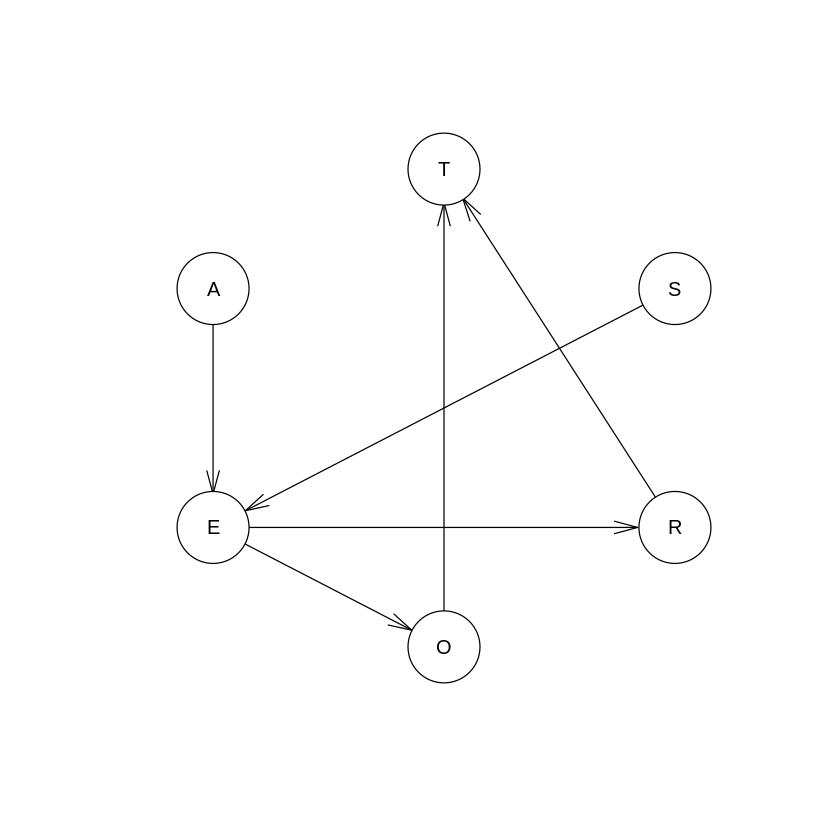

In [181]:
# Definition of the model using a string
model.string <- "[A][S][E|A:S][O|E][R|E][T|O:R]"
dag <- model2network(model.string)
plot(dag)

En el caso de los datos de esta encuesta, y en general en el caso de redes bayesianas discretas, los parámetros a estimar son las probabilidades condicionales de las distribuciones locales de cada nodo. Pueden ser estimadas de manera sencilla, computando las distintas tablas de frecuencias empíricas del conjunto de datos. Por ejemplo:

$$
  \begin{aligned}
  \hat P(\mathrm{\texttt{O = emp | E = high}}) = \frac{\hat P(\mathrm{\texttt{O = emp,E = high}})}{\hat P(\mathrm{\texttt{E = high}})} \\
  = \frac{\mathrm{número~de~observaciones~en~las~que~\texttt{O = emp}~y~\texttt{E = high}}}{\mathrm{número~de~observaciones~en~las~que~\texttt{E = high}}}
  \end{aligned}
$$

Este procedimiento es muy sencillo, y podríamos hacerlo de manera manual de forma fácil. Por ejemplo, la probabilidad estimada de ser trabajador por cuenta ajena, $\hat P(O = emp)$ se calcula simplemente:

In [182]:
length(which(survey$O == "emp")) / length(survey$O)   

[1] 0.966

Del mismo modo, la probabilidad de ser empleado por cuenta ajena dado un nivel educativo universitario, $\hat P(O = emp | E = uni)$, puede calcularse:

In [183]:
length(which(survey$O == "emp" & survey$E == "uni")) / length(which(survey$E == "uni"))

[1] 0.9259259

La función de R `prop.table` permite calcular de forma directa las tablas de probabilidades marginales para cada combinación, por ejemplo $P(O|E)$ se calcularía así:

In [184]:
prop.table(table(survey[ , c("O", "E")]), margin = 2)

      E
O            high        uni
  emp  0.98082192 0.92592593
  self 0.01917808 0.07407407

y así sucesivamente... Este proceso se realiza de forma automática utilizando la función `bn.fit`, que además introduce algunas variaciones sobre el ejemplo expuesto anteriormente. La función `bn.fit` complementa a la función `custom.fit` utilizada anteriormente para introducir las tablas de probabilidad de forma manual en la red, mientras que `bn.fit` las estima a partir de un conjunto de datos dado.

En el caso de la distribución discreta multinomial, pueden utilizarse dos métodos para la estimación de los resultados (*maximum likelihood* y *bayesian estimation*). El primero, se corresponde exactamente con la aproximación clásica de cálculo de las frecuencias empíricas expuesto en las líneas anteriores (estimación por máxima verosimilitud):

In [185]:
bn.mle <- bn.fit(dag, data = survey, method = "mle")
# Ejemplo anterior:
bn.mle$O


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O            high        uni
  emp  0.98082192 0.92592593
  self 0.01917808 0.07407407

Nótese las sutiles diferencias utilizando el método de estimación Bayesiano:

In [186]:
bn.bayes <- bn.fit(dag, data = survey, method = "bayes")
bn.bayes$O    


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O            high        uni
  emp  0.98016416 0.92435424
  self 0.01983584 0.07564576

Mientras que el método de estimación de máxima verosimilitud (`mle`) extrae las probabilidades de forma empírica a través de los datos, tal y como podemos hacer manualmente de forma directa usando `table` y `prop.table`, el método `bayes` ajusta los datos a una función de distribución y estima dichos valores de probabilidad. Esto último, es más conveniente, ya que puede suceder que haya combinaciones en las tablas de probabilidad condicionada que no se encuentren en los datos, que va a limitar la capacidad de aprendizaje de nuestra red cuando intentemos hacer inferencia a partir de nuevas evidencias.

Además, en líneas generales, podemos decir que las tablas estimadas con el método `bayes` son más robustas que las `mle` dando lugar a redes bayesianas con mayor capacidad predictiva.

## 6 Representación gráfica avanzada

Una de las grandes ventajas de las redes Bayesianas consiste en poder estudiarlas de forma visual a partir de su representación gráfica. A continuación se muestran algunas de las herramientas disponibles en R para la representación gráfica de redes bayesianas.

### 6.1 Dibujar un DAG

`bnlearn` se basa en las herramientas disponibles en el paquete `Rgraphviz` para dibujar estructuras gráficas, a través de la función `graphviz.plot`. De hecho, la llamada a esta función con todos los argumentos por defecto da lugar a los gráficos que hemos visto anteriormente usando directamente `plot`.

Una operación típica es resaltar un nodo(s) en particular. Por ejemplo, si queremos significar una conectividad de tipo convergente ([recuerda aquí](#dag.struc)) en nuestro grafo, podemos hacerlo del siguiente modo: Primero, vamos a definir el color gris para todos los nodos del DAG:

In [96]:
hlight <- list(nodes = nodes(dag), arcs = arcs(dag), col = "grey", textCol = "grey")

A continuación, le pasamos esta lista de especificaciones a la función `graphviz.plot` a través de su argumento `highlight`:

[1] "graphNEL"
attr(,"package")
[1] "graph"

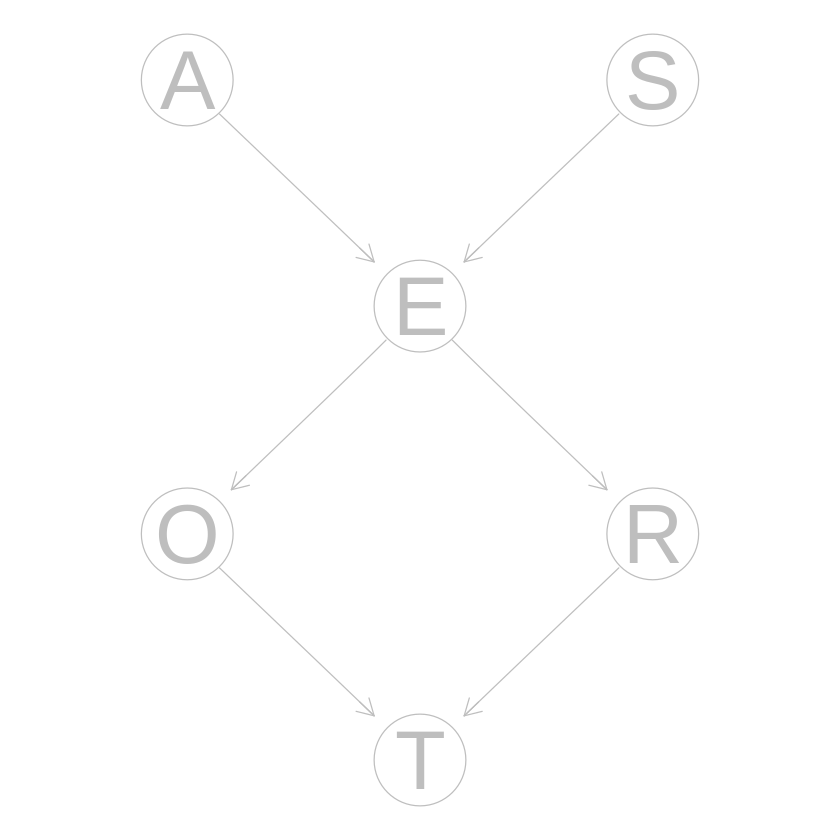

In [97]:
pp <- graphviz.plot(dag, highlight = hlight)
class(pp)

El aspecto de los arcos se puede modificar utilizando `edgeRenderInfo`, y una lista cuyos elementos son los elementos gráficos que se desea modificar:

In [98]:
edgeRenderInfo(pp) <- list(col = c("A~E" = "black", "S~E" = "black"), # color
                           lwd = c("A~E" = 2.5, "S~E" = 2.5)) # grosor

Del mismo modo, manipulamos el aspecto de los nodos con `nodeRenderInfo`:

In [99]:
nodeRenderInfo(pp) <- list(col = c("S" = "black", "E" = "black", "A" = "black"),
                           textCol = c("S" = "black", "E" = "black", "A" = "black"),
                           fill = c("E" = "grey"))

Una vez introducidas todas las modificaciones, se pinta el grafo con `renderGraph`:

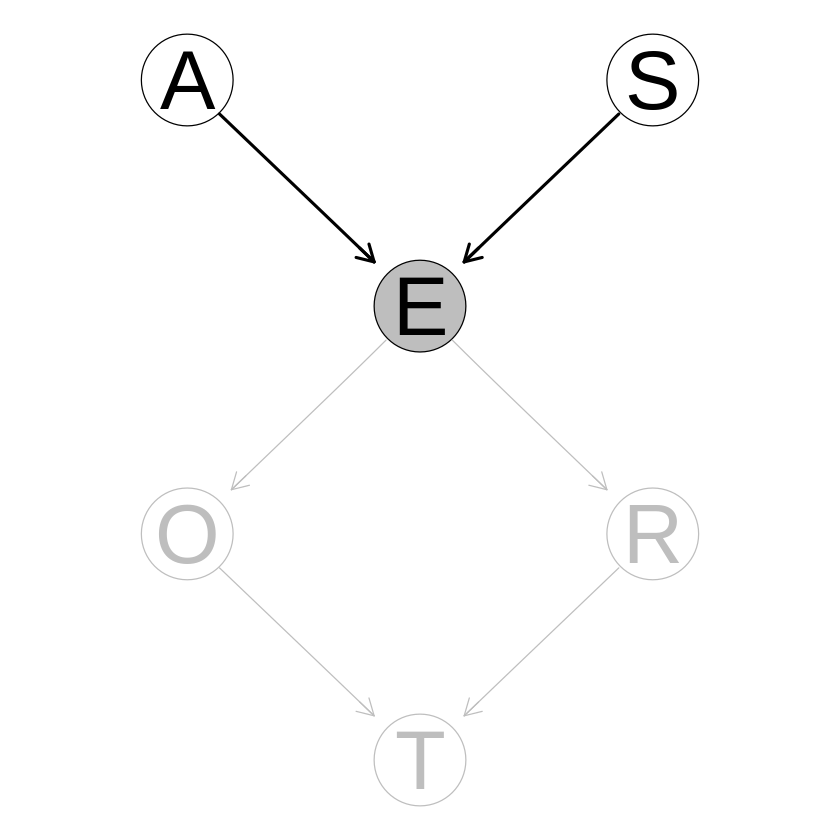

In [100]:
renderGraph(pp)

Otro ejemplo de personalizacion consiste en resaltar las v-estructuras del grafo:

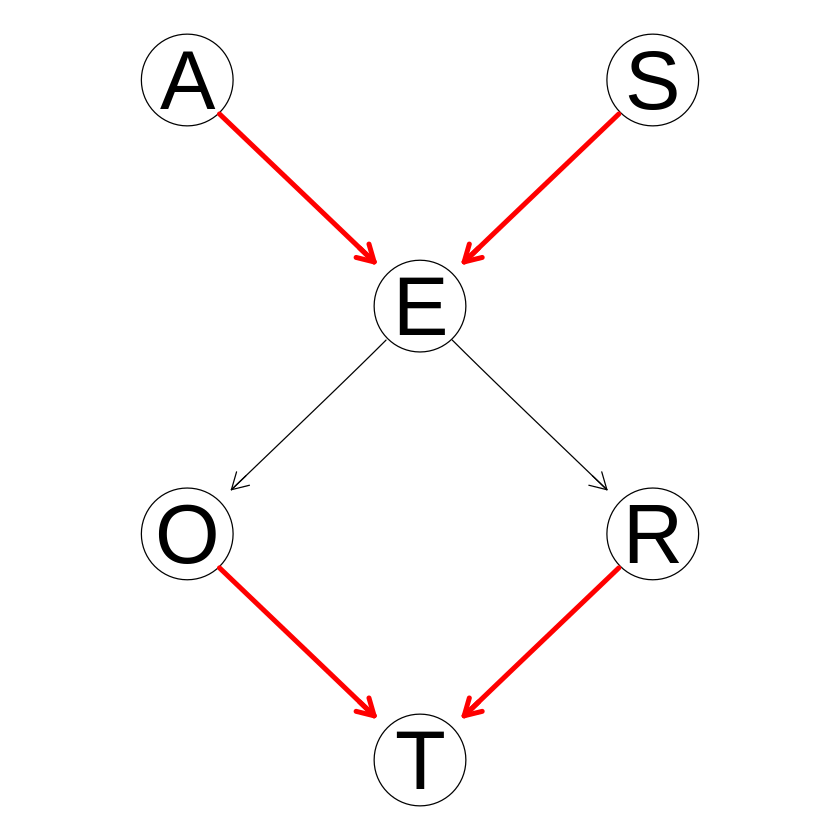

In [101]:
hl <- list(arcs = vstructs(dag, arcs = TRUE), lwd = 4, col = "red")
graphviz.plot(dag, highlight = hl)

Existen además otras posibles configuraciones para representar los DAG. Estas son las alternativas que ofrece la función `graphviz.plot`, y que se encuentran documentadas en la viñeta del paquete `Rgraphviz`:

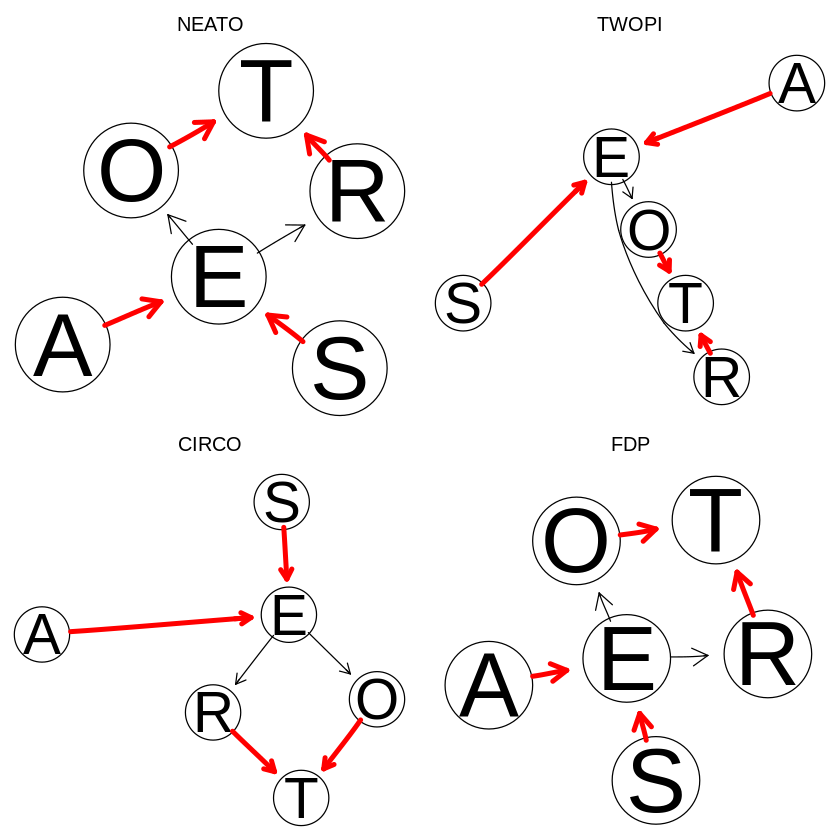

In [102]:
# Valor por defecto (layout = "dot"):
# graphviz.plot(dag, highlight = hl, layout = "dot")
par(mfrow = c(2,2))
for (i in c("neato", "twopi", "circo", "fdp")) {
      graphviz.plot(dag, highlight = hl, layout = i, main = toupper(i))
}

### 6.2 Gráficos de distribución de probabilidades condicionales

Se trata de gráficos de gran utilidad en el análisis y exploración del modelo. Las funciones implementadas en `bnlearn` se basan en las herramientas del potente paquete `lattice` para visualización de datos multivariantes.

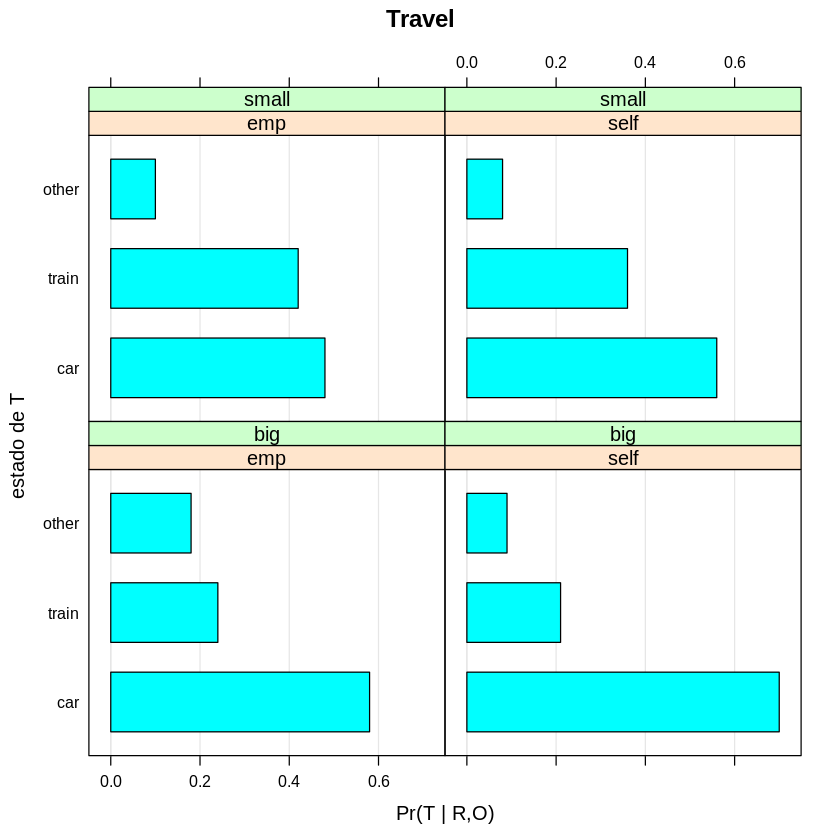

In [103]:
# Barras
bn.fit.barchart(bn$T, main = "Travel", xlab = "Pr(T | R,O)", ylab = "estado de T")

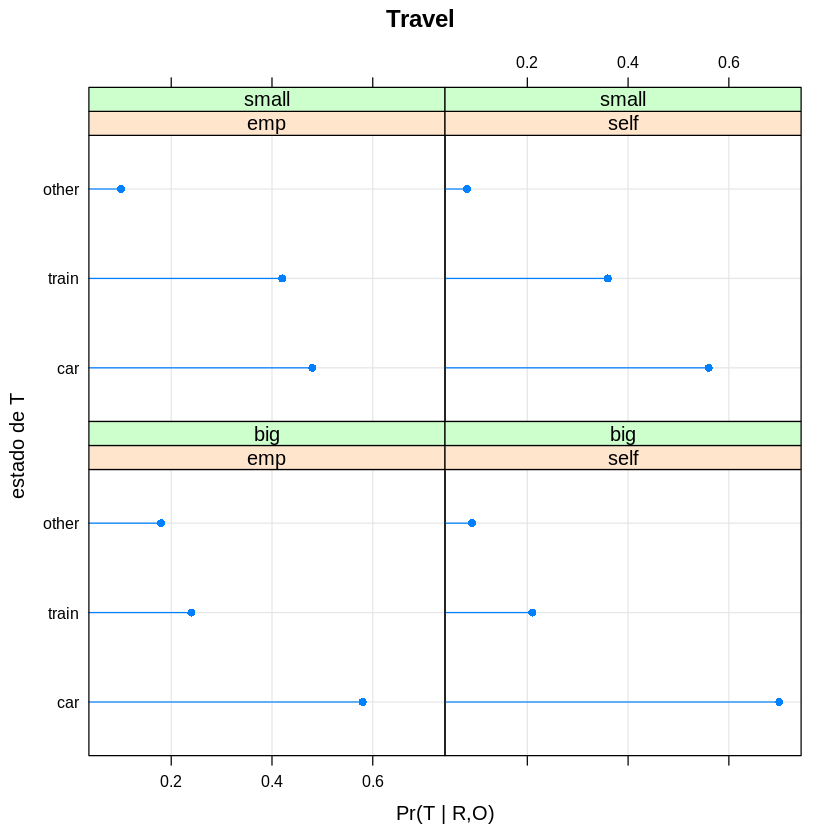

In [104]:
# Puntos
bn.fit.dotplot(bn$T, main = "Travel", xlab = "Pr(T | R,O)", ylab = "estado de T")

## 7 Ejemplo con el dataset `Groceries` 

Dado que en la pasada sesión práctica se ha trabajado con el dataset Groceries, es interesante comprobar la consistencia entre los resultados obtenidos por las reglas de asociación, un método como vimos relativamente sencillo de aprender de los datos, y las redes bayesianas.

Para ello, es necesario recuperar los datos de `Groceries`, contenidos en el paquete `arules`, y realizar algunas transformaciones para poder trabajar con ellos adecuadamente. Se incluyen todos los pasos en el preproceso de los datos, ya que con frecuencia gran parte del trabajo en minería de datos se corresponderá a tareas de limpieza y preparación de los datos, tediosas a veces, sí, pero necesarias.

In [59]:
library(arules)

Loading required package: Matrix

Attaching package: ‘arules’

The following object is masked from ‘package:bnlearn’:

    discretize

The following objects are masked from ‘package:base’:

    abbreviate, write



In [63]:
data('Groceries')

In [64]:
str(Groceries)

Formal class 'transactions' [package "arules"] with 3 slots
  ..@ data       :Formal class 'ngCMatrix' [package "Matrix"] with 5 slots
  .. .. ..@ i       : int [1:43367] 13 60 69 78 14 29 98 24 15 29 ...
  .. .. ..@ p       : int [1:9836] 0 4 7 8 12 16 21 22 27 28 ...
  .. .. ..@ Dim     : int [1:2] 169 9835
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : NULL
  .. .. .. ..$ : NULL
  .. .. ..@ factors : list()
  ..@ itemInfo   :'data.frame':	169 obs. of  3 variables:
  .. ..$ labels: chr [1:169] "frankfurter" "sausage" "liver loaf" "ham" ...
  .. ..$ level2: Factor w/ 55 levels "baby food","bags",..: 44 44 44 44 44 44 44 42 42 41 ...
  .. ..$ level1: Factor w/ 10 levels "canned food",..: 6 6 6 6 6 6 6 6 6 6 ...
  ..@ itemsetInfo:'data.frame':	0 obs. of  0 variables


In [69]:
str(Groceries@data)

Formal class 'ngCMatrix' [package "Matrix"] with 5 slots
  ..@ i       : int [1:43367] 13 60 69 78 14 29 98 24 15 29 ...
  ..@ p       : int [1:9836] 0 4 7 8 12 16 21 22 27 28 ...
  ..@ Dim     : int [1:2] 169 9835
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ factors : list()


In [70]:
str(Groceries@itemInfo)

'data.frame':	169 obs. of  3 variables:
 $ labels: chr  "frankfurter" "sausage" "liver loaf" "ham" ...
 $ level2: Factor w/ 55 levels "baby food","bags",..: 44 44 44 44 44 44 44 42 42 41 ...
 $ level1: Factor w/ 10 levels "canned food",..: 6 6 6 6 6 6 6 6 6 6 ...


In [71]:
str(Groceries@itemInfo$labels)

 chr [1:169] "frankfurter" "sausage" "liver loaf" "ham" "meat" ...


In [72]:
print(Groceries@itemInfo$labels)

  [1] "frankfurter"               "sausage"                  
  [3] "liver loaf"                "ham"                      
  [5] "meat"                      "finished products"        
  [7] "organic sausage"           "chicken"                  
  [9] "turkey"                    "pork"                     
 [11] "beef"                      "hamburger meat"           
 [13] "fish"                      "citrus fruit"             
 [15] "tropical fruit"            "pip fruit"                
 [17] "grapes"                    "berries"                  
 [19] "nuts/prunes"               "root vegetables"          
 [21] "onions"                    "herbs"                    
 [23] "other vegetables"          "packaged fruit/vegetables"
 [25] "whole milk"                "butter"                   
 [27] "curd"                      "dessert"                  
 [29] "butter milk"               "yogurt"                   
 [31] "whipped/sour cream"        "beverages"                
 [33] "U

A continuación, vamos a crear un conjunto de reglas con el algoritmo *a priori*. Elegimos por ejemplo un soporte de los datos del 0.1\%, y una confianza del 30\%, y vemos de entro todo el conjunto de reglas generado, qué regla tiene un mayor *lift* (recordemos que el lift era una medida de dependencia en términos de probabilidad):

In [66]:
rules <- apriori(Groceries,
                 parameter = list(support = 0.001, confidence = 0.3))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5   0.001      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 9 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[169 item(s), 9835 transaction(s)] done [0.00s].
sorting and recoding items ... [157 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 5 6 done [0.02s].
writing ... [13770 rule(s)] done [0.00s].
creating S4 object  ... done [0.01s].


In [67]:
inspect(head(sort(rules, by = "lift"), 1))

    lhs                              rhs      support     confidence lift    
[1] {bottled beer,red/blush wine} => {liquor} 0.001931876 0.3958333  35.71579
    count
[1] 19   


La regla de asociación nos dice que existe una asociación elevada entre la compra de cerveza embotellada y vino, y la compra de licor. Expresado en términos de probabilidad, diríamos que de acuerdo con esta regla, podríamos esperar que $P(liquor|beer,wine) >> P(liquor)$. vamos a comprobar si una red bayesiana respalda esta afirmación.

### 7.1 Preparación de los datos

Recordemos que la matriz de datos se encuentra dentro del elemento `@data`. Además, el metadato necesario (en este caso los nombres de los diferentes productos de la compra, están dentro de `Groceries@itemInfo$labels`).

In [73]:
b <- t(as.matrix(Groceries@data))
product.names <- Groceries@itemInfo$labels

El motivo de trabajar con matrices huecas para este tipo de datos, comentado en la pasada sesión de reglas de asociación, es evidente si observamos el tamaño en memoria de la matriz original, y lo comparamos con el de la nueva matriz ordinaria, que es más de 60 veces mayor, conteniendo una gran cantidad de ceros:

In [74]:
print(object.size(Groceries), units = "Mb")
print(object.size(b), units = "Mb")

0.2 Mb
6.3 Mb


A continuación, vamos a evitar algunos caracteres especiales y espacios dentro de los nombre de los productos, ya que en general no es buena idea crear un `data.frame` con este tipo de caracteres en los nombres de las columnas, ya que pueden dar lugar a diversos errores. Utilizaremos la función `gsub` para reemplazar estos caracteres problemáticos del siguiente modo:

In [76]:
# Se sustituyen algunos caracteres especiales en las etiquetas que pudieran 
# ser problemáticos, tales como:
# Barras
product.names <- gsub("/","_or_", product.names)
# Espacios en blanco
product.names <- gsub(" ","_", product.names)
# Parentesis
product.names <- gsub("(","", product.names, fixed = TRUE)
product.names <- gsub(")","", product.names, fixed = TRUE)
# Puntos
product.names <- gsub(".","", product.names, fixed = TRUE)
colnames(b) <- product.names

In [77]:
head(sort(colSums(b), decreasing = TRUE))

whole_milk other_vegetables    rolls_or_buns             soda 
            2513             1903             1809             1715 
          yogurt    bottled_water 
            1372             1087

In [78]:
tail(sort(colSums(b), decreasing = TRUE))

baby_cosmetics       kitchen_utensil                  bags 
                    6                     4                     4 
preservation_products             baby_food  sound_storage_medium 
                    2                     1                     1

Parece razonable por lo tanto descartar aquellos productos raros, y centrarse en los principales (recordemos que la regla está basada en un support de 0.01). Si tomamos por ejemplo los 100 productos más numerosos, aseguraremos un número mínimo de registros que permitirán construir un modelo bayesiano más robusto, descartando casos raros.

In [79]:
filter.products <- names(sort(colSums(b), decreasing = TRUE)[1:100])
ind <- match(filter.products, product.names)
b <- b[,ind]

Además, nos aseguramos de que la variable es categórica con el método de coerción `as.factor`. El resultado final, es un `data.frame` con productos en columnas y transacciones en filas (el mismo formato en que hemos trabajado el conjunto de datos `survey`): 

In [80]:
b <- apply(b, 2, "as.factor")
groc <- as.data.frame(b)

In [81]:
head(groc)

whole_milk,other_vegetables,rolls_or_buns,soda,yogurt,bottled_water,root_vegetables,tropical_fruit,shopping_bags,sausage,⋯,mayonnaise,sweet_spreads,chocolate_marshmallow,candles,specialty_cheese,dog_food,frozen_potato_products,house_keeping_products,turkey,Instant_food_products
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


### 7.2 Construcción de la BN

A continuación, construimos la red. Obviamente, dado el tamaño de la base de datos, no resulta viable indicar una estructura de grafo. Es una típica tarea de aprendizaje estructural automático. En este caso, la resolveremos con el algoritmo *hill-climbing*

In [82]:
grafo <- hc(groc, debug = FALSE)

Una vez aprendido el grafo, calculamos los parámetros asociados a cada nodo con `bn.fit`:

In [83]:
# Aprendizaje paramétrico
redb <- bn.fit(x = grafo, data = groc, method = "bayes")

Resulta ineteresante destacar la dramática reducción en el número de parámetros gracias a la red bayesiana, que resulta mucho más llamativa que en el ejemplo `survey`:

In [84]:
print(2^100 - 1)

[1] 1.267651e+30


In [85]:
nparams(redb)

[1] 399

Obviamente, se trata de una red de cierta complejidad, dado el número de nodos (100) y arcos:

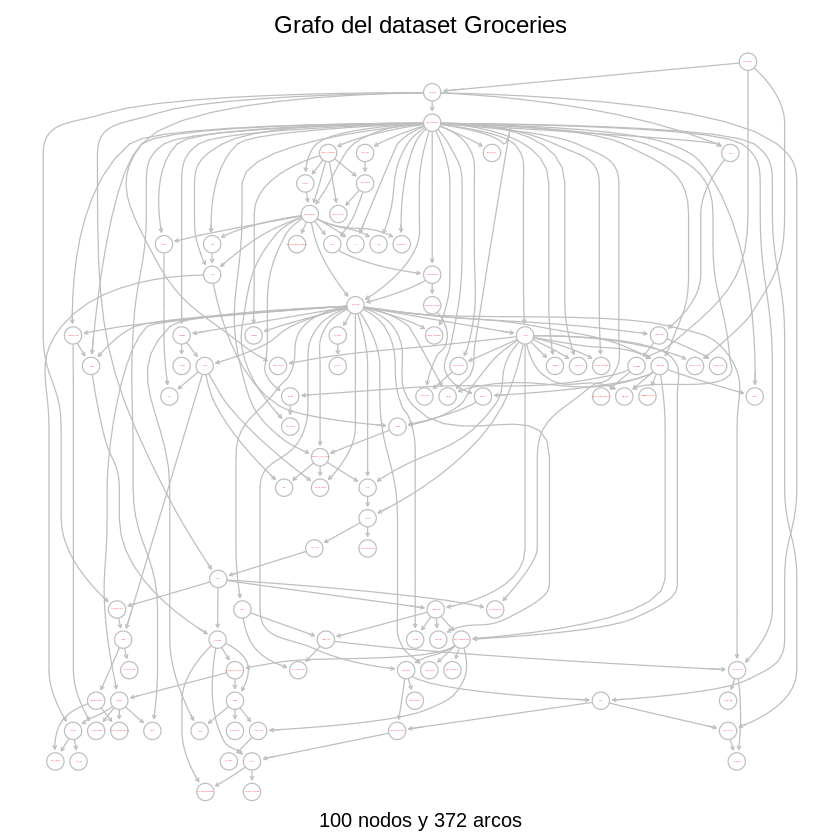

In [86]:
hlight <- list(nodes = nodes(grafo),
               arcs = arcs(grafo), col = "grey", textCol = "red")
pp <- graphviz.plot(grafo, highlight = hlight,
                    main = "Grafo del dataset Groceries",
                    sub = paste(length(nodes(grafo)),"nodos y",
                                length(arcs(grafo)), "arcos"))

### 7.3 Consultas

Recordemos la regla de asociación, que indica una relacion entre la cerveza y el vino, y la compra de licores.

In [87]:
inspect(head(sort(rules, by = "lift"), 1))

    lhs                              rhs      support     confidence lift    
[1] {bottled beer,red/blush wine} => {liquor} 0.001931876 0.3958333  35.71579
    count
[1] 19   


Desde un punto gráfico, podemos comprobar que existe una asociación en términos de probabilidad entre estos elementos de la cesta de la compra, en concordancia con lo previsto por la regla de asociación, ya que:

1. Se encuentran formando una estructura en V (lo cual implica dependencia condicional):

In [88]:
vs <- vstructs(grafo)
vs[which(apply(vs, 1, function(x) grep("liquor", x)) != 0), ]

X               Z               Y 
"bottled_water"  "bottled_beer"        "liquor"

2. Tanto la cerveza como el vino se encuentran dentro de la manta de Markov de licores:

In [89]:
mb(grafo, node = "liquor")

[1] "whole_milk"        "bottled_water"     "bottled_beer"     
[4] "red_or_blush_wine"

Vamos a comprobarlo de forma analítica, utilizando para ello inferencia aproximada. Así, comprobamos que la probabilidad conjunta *a priori* de cerveza y vino es baja:   

In [90]:
cpquery(redb,
        event = (bottled_beer == TRUE) & (red_or_blush_wine == TRUE),
        evidence = (liquor == FALSE))

[1] 0.002766718

Mientras que la misma probabilidad, condicionada por la compra de licor, aumenta notablemente:

In [91]:
cpquery(redb,
        event = (bottled_beer == TRUE) & (red_or_blush_wine == TRUE),
        evidence = (liquor == TRUE))

[1] 0.1666667

Dado que estamos realizando inferencia aproximada, los resultados no son exactos, y por lo tanto se mueven dentro de un margen de error muestral. Veamos los resultados tras 100 realizaciones:

In [92]:
liq.no <- liq.yes <- rep(NA,100)
for (i in 1:100) {
    liq.no[i] <- cpquery(redb,
                         event = (bottled_beer == TRUE) & (red_or_blush_wine == TRUE),
                         evidence = (liquor == FALSE))
    liq.yes[i] <- cpquery(redb,
                          event = (bottled_beer == TRUE) & (red_or_blush_wine == TRUE),
                          evidence = (liquor == TRUE))
}
df <- cbind.data.frame("P(b,w|l=TRUE)" = liq.yes,
                       "P(b,w|l=FALSE)" = liq.no)

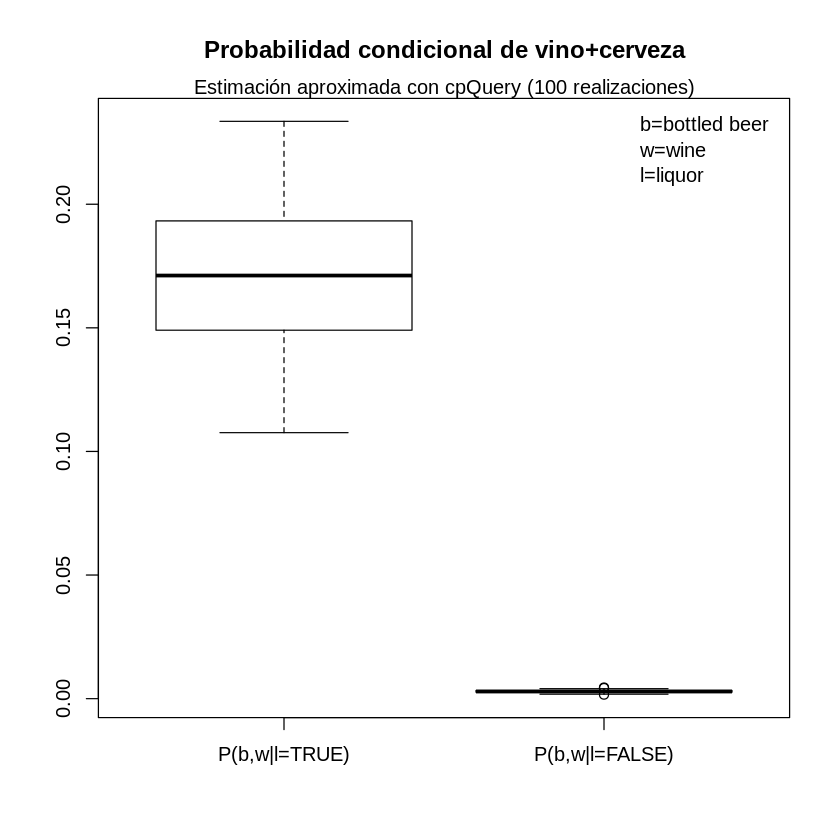

In [93]:
boxplot(df, main = "Probabilidad condicional de vino+cerveza")
mtext("Estimación aproximada con cpQuery (100 realizaciones)")
legend("topright", c("b=bottled beer","w=wine","l=liquor"), bty = "n")

Queda por lo tanto corrobarado el resultado de la regla de asociación a través del modelo bayesiano.

## 8 Validación cruzada y redes bayesianas

Como se ha visto en anteriores sesiones, la validación cruzada es una técnica ampliamente utilizada para la obtención de estimadores insesgados de la bondad de ajuste de nuestro modelo. Dado que existen diferentes algoritmos de aprendizaje paramétrico y estructural, es posible realizar la selección de uno óptimo basándose técnicas de validación cruzada, basándose de nuevo en algún tipo de score de referencia.

En principio resulta sencillo lanzar una validación cruzada repitiendo recursivamente los pasos anteriormente realizados de construccion del DAG y ajuste de los datos. Alternativamente, y de forma mucho más directa, `bnlearn` incorpora esta funcionalidad en la función `bn.cv`, que incorpora los esquemas de validación cruzada *k-fold* y *hold-out*, vistos en sesiones anteriores, y *custom* (el usuario define explícitamente los *folds*)

El valor de referencia para evaluar la bondad del ajuste (*loss function*) viene dado por el argumento `loss`. Por defecto, utiliza el denominado *log-likelihood loss (logl)*, que es la log-verosimilitud (con signo negativo delante) de los datos de test, dada la red construida con los datos de entrenamiento. Por lo tanto, cuanto menor sea *logl*, mejor será el ajuste de la red a los datos. La [ayuda](http://www.bnlearn.com/documentation/man/bn.cv.html) de `bn.cv()` propociona una descripción más detalladas de las diferentes funciones de coste disponibles y su interpretación. 

### 8.1 Ejemplo de aplicación de validación cruzada con el dataset `Groceries`

Dado nuestro escaso conocimiento inicial de las relaciones entre productos de la compra de este conjunto de datos, vamos a probar diferentes configuraciones de la red para ver cuál podría resultar en un mejor ajuste.

Comenzamos probando la que hemos utilizado en la sección anterior, ajustada con hill-climbing

In [94]:
hill <- bn.cv(groc, bn = "hc")
print(hill)

Warning message in entropy.loss(fitted = fitted, data = data, debug = debug):
“2 observations were dropped because the corresponding probabilities for node candy were 0 or NaN.”Warning message in entropy.loss(fitted = fitted, data = data, debug = debug):
“2 observations were dropped because the corresponding probabilities for node candy were 0 or NaN.”Warning message in entropy.loss(fitted = fitted, data = data, debug = debug):
“1 observations were dropped because the corresponding probabilities for node frozen_meals were 0 or NaN.”Warning message in entropy.loss(fitted = fitted, data = data, debug = debug):
“1 observations were dropped because the corresponding probabilities for node semi-finished_bread were 0 or NaN.”Warning message in entropy.loss(fitted = fitted, data = data, debug = debug):
“1 observations were dropped because the corresponding probabilities for node frozen_dessert were 0 or NaN.”Warning message in entropy.loss(fitted = fitted, data = data, debug = debug):
“2 obse


  k-fold cross-validation for Bayesian networks

  target learning algorithm:             Hill-Climbing 
  number of folds:                       10 
  loss function:                         Log-Likelihood Loss (disc.) 
  expected loss:                         15.20992 



Como vemos, se produce un resumen en pantalla del que podemos extraer la bondad de ajuste. 

Comparemos ahora esta aproximación con otros algoritmos de aprendizaje estructural alternativos. No vamos a probarlos todos, pero a modo de ejemplo, compararemos otro algritmo similar a *hill-climbing* (también basado en scores globales de la red) llamado *tabu*. Además, veremos cómo se comporta el ajuste con algoritmos basados en tests de independencia, siendo los más frecuentes `iam` (*incremental association*), y su variante optmizada que proporciona mayor rapidez en el cálculo (`fast.iamb`). Además, incorporamos el argumento `k=5`, para definir el número de folds (por defecto `k=10`) de forma manual, y el argumento `runs`, que indica el número de realizaciones generadas por `bn.cv()`

**::GMG::** Paro aquí :)

```r
# NOTA: Este código puede conllevar varios minutos de cálculo, dependiendo de las características de la máquina
algs <- c("hc", "tabu")
cv.list <- lapply(1:length(algs), function(i) {
    message("[", Sys.time(), "] - Validando de forma cruzada el algoritmo (k=5) \'",
            algs[i], "'")
    suppressMessages(bn.cv(groc, bn = algs[i], k = 5, runs = 10))
})
```

De acuerdo con los resultados de la validación cruzada, parece que en las condiciones del análisis realizado, el algoritmo hill-climbing resulta el más competitivo:

```r
lapply(cv.list, "print")
```

```r
do.call("plot", cv.list)
```

## 9 Computación en paralelo

Como ha podido comprobarse en los últimos cálculo con el dataset `Groceries`, la construcción de redes bayesianas, y en particular la fase de aprendizaje estructural, es un problema computacionalmente costoso. Este limitación se exacerba para conjuntos de datos aún mayores, que con frecuencia se encuentran en el día a día de la minería de datos. Por ello, el paquete `bnlearn` aprovecha la capacidad de R para trabajar en paralelo, y en particular explota las implementaciones de bucles en paralelo del paquete `parallel` para optimizar el tiempo de cómputo. 

A continuación se muestra un ejemplo de como crear un objeto de tipo `cluster` en nuestra máquina de trabajo (aplicable a cualquier procesador multi-core actual), y pasárselo a `bnlearn` de forma directa:

**NOTA**: este ejemplo asume que se dispone de un procesador multicore en la máquina de trabajo. De lo contrario, no tiene sentido realizar la comparación.

Lo primero, comprobamos el tiempo requerido para ajustar la red con el algoritmo hill climbing utilizando un único procesador, como hemos hecho hasta ahora:

```r
tiempo_serie <- system.time({out <- bn.cv(data = groc, bn = "hc", k = 5, cluster = NULL)})["elapsed"]
tiempo_serie
```

Ahora, configuramos un cluster, utilizando todas las unidades de proceso de nuestro procesador (dejando una libre).

```r
library(parallel)
# Autodetecta el numero de nodos
nw <- detectCores() - 1
# Configura el cluster
.cl <- makeCluster(spec = nw)
```

Una vez definido el objeto `cluster`, que hemos llamdo `.cl`, basta con pasárselo a la función de turno en `bn.learn` (en este ejemplo `bn.cv()`, pero podría también pasarse a `bn.fit()`, etc.)

```r
# Se lo pasa a bn.cv
tiempo_par <- system.time({
    message("Aplicando hill-climbing con ", nw, " cores en paralelo")
    out2 <- bn.cv(data = groc, bn = "hc", k = 5, cluster = .cl)
})["elapsed"]
# Al finalizar, es necesario parar el cluster 
stopCluster(.cl)
tiempo_par['elapsed']
```

Vemos que el tiempo transcurrido ha disminuído, aunque esta cantidad dependerá de varios factores, entre ellos fundamentalmente de las características de la máquina en que se haya ejecutado el ejemplo.

## 10 Referencias

* Gutiérrez, J.M., Cano, R., Cofiño, A.S., Sordo, C., 2004. Redes probabilísticas y neuronales en las ciencias atmosféricas. Centro de Publicaciones, Ministerio de Medio Ambiente, Madrid, Spain.

* Scutari, M., Denis, J.-B., 2014. Bayesian networks: with examples in R.

* Scutari, M., 2014. Bayesian Network Constraint-Based Structure Learning Algorithms: Parallel and Optimised Implementations in the bnlearn R Package. http://arxiv.org/abs/1406.7648

* r-bayesian-networks. http://www.r-bayesian-networks.org/ (Last accessed 18 Nov 2017)

* Nagarajan, R., Scutari, M. and Lèbre, S. 2013. Bayesian networks in R: with applications in systems biology, Use R! Springer, New York.

## 11 Session info

In [95]:
print(sessionInfo())

R version 3.4.4 (2018-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] arules_1.6-1        Matrix_1.2-14       Rgraphviz_2.22.0   
[4] gRain_1.3-0         gRbase_1.8-3.4      RBGL_1.54.0        
[7] graph_1.56.0        BiocGenerics_0.24.0 bnlearn_4.4.1      

loaded via a namespace (and not attached):
 [1] igrap